## Imports

In [7]:
from torch.utils.data import DataLoader
from torch.autograd import Variable
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
import zipfile

import math

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from os import listdir
import h5py as h5
import os
import time
import multiprocessing
from tqdm import tqdm
import time
from PIL import Image

In [8]:
try:
    import gwpy
    from gwpy.timeseries import TimeSeries
except ModuleNotFoundError:
    !pip install --quiet gwpy
    import gwpy
    from gwpy.timeseries import TimeSeries

In [9]:
if torch.cuda.is_available():
    device = 'cuda'
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    device = 'cpu'

NVIDIA A100-PCIE-40GB


In [10]:
device

'cuda'

# Create  Synthetic Dataset

In this section, we create a synthetic dataset to train generative models with.

The section is split in two parts:
- 1) **TimeSeries Dataset** Generation of a gwpy TimeSeries dataset making use of random noise and sinusoidal functions
- 2) **Q-plot Dataset** Conversion of TimeSeries dataset into 2D Image dataset making use of q_transform

The dataset used to train the NN with is created as a 2D images. Note that you do not need to run the two sectiosn each time, but can rather save the dataset after creating it once and loading it at the beginning of Process Data that to save time

## TimeSeries Dataset

In [79]:
def generate_dataset_aux_channels(rows, columns, duration=10, sample_rate=500, num_waves_range=(10, 15), noise_amplitude=0.1):
    """
    Generate a Pandas DataFrame with randomly generated smooth sine wave time series with added smooth random noise.
    
    Parameters:
        - rows (int): Number of rows in the DataFrame.
        - columns (int): Number of columns in the DataFrame.
        - duration (float): Duration of the time series data in seconds (default is 6 seconds).
        - sample_rate (int): Sampling rate of the time series data in samples per second (default is 500 samples per second).
        - num_waves_range (tuple): Range for the random number of sine waves to be generated for each time series.
                                   Format: (min_num_waves, max_num_waves) (default is (10, 15)).
        - noise_amplitude (float): Amplitude of the smooth random noise added to the time series data (default is 0.1).
    
    Returns:
        - DataFrame: Pandas DataFrame containing the generated time series data.
    """
    # Generate time array
    times = np.linspace(0, duration, duration * sample_rate)
    
    # Initialize an empty list to store individual DataFrames for each row
    dfs = []
    columns_list= [f'Aux_{i+1}' for i in range(columns)]
    
    for index in range(rows):
        df_dict={}
        for col in range(columns):
            # Initialize an array to store the generated wave data for this row
            wave_data = np.zeros(len(times))
            # Determine the number of sine waves to generate for this column randomly
            num_waves = np.random.randint(*num_waves_range)
            
            # Generate each sine wave
            for _ in range(num_waves):
                # Randomly generate parameters for the sine wave (amplitude, frequency, phase)
                amplitude = np.random.uniform(0.5, 2.0)
                frequency = np.random.uniform(0.5, 5.0)
                phase = np.random.uniform(0, 2*np.pi)
                
                # Generate the sine wave and add it to the wave_data
                wave_data += amplitude * np.sin(2 * np.pi * frequency * times + phase)
            
            # Add smooth random noise to the wave data
            smooth_noise = np.random.normal(0, noise_amplitude, len(times))
            wave_data += smooth_noise
        
            # Create a TimeSeries object from the wave data
            ts = TimeSeries(wave_data, t0=0, dt=1/sample_rate)
            df_dict[f'Aux_{col+1}']=[ts]
            
        #Create a DataFrame with the TimeSeries
        df_row = pd.DataFrame(df_dict)
        
        # Append the DataFrame to the list
        dfs.append(df_row)
    
    # Concatenate the list of DataFrames into a single DataFrame along rows axis
    df = pd.concat(dfs, ignore_index=True, axis=0)
    
    return df


In [114]:
def generate_dataset_main_channel(input_df, weights=None, noise_amplitude=0.1):
    """
    Generate a dataset where each row of a single column is a weighted linear combination of the entries
    in the corresponding row in the input DataFrame plus random noise.
    
    Parameters:
        - input_df (DataFrame): Input DataFrame generated by generate_smooth_noisy_sine_wave_series.
        - weights (array-like): Optional weights for each entry in the row. If None, random weights are generated (default is None).
        - noise_amplitude (float): Amplitude of the random noise added to the linear combination (default is 0.1).
    
    Returns:
        - DataFrame: Pandas DataFrame containing the generated linear combination dataset.
    """
    dt=input_df.iloc[0,0].dt
    # Initialize an empty list to store the linear combination values
    linear_combination_data = []
    
    # Generate random weights if not provided
    if weights is None:
        weights = np.random.rand(len(list(input_df.columns)))+ 0.5 # randomly generate weights in range [0.5,1.5]
    print(weights)
    # Iterate over rows of the input DataFrame
    for index, row in input_df.iterrows():
        
        
        # Compute the weighted linear combination of the row values
        linear_combination = np.sum(row * weights)
        
        # Add random noise to the linear combination
        linear_combination += np.random.normal(0, noise_amplitude)
        
        # Append the result to the list
        linear_combination_data.append([TimeSeries(linear_combination,dt=dt,t0=0)])
    
    # Create a DataFrame with the linear combination data
    linear_combination_df = pd.DataFrame(linear_combination_data, columns=['Main'])
    
    return linear_combination_df

In [82]:
df_aux_ts=generate_dataset_aux_channels(1000, 3, duration=16, sample_rate=500, num_waves_range=(20, 25), noise_amplitude=0.6)

In [115]:
df_main_ts=generate_dataset_main_channel(df_aux_ts, weights=None, noise_amplitude=0.1)

[0.54066178 1.37966576 1.00840498]


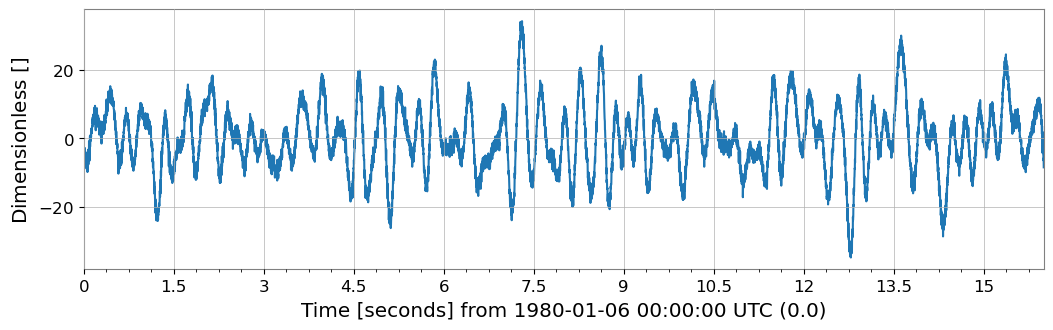

In [84]:
df_main_ts.iloc[0,0].plot()
plt.show()

In [85]:
#save datasets 
save_name_main='TimeSeries_dataset_synthetic_main.pkl'
save_name_aux='TimeSeries_dataset_synthetic_aux.pkl'
df_main_ts.to_pickle(save_name_main)
df_aux_ts.to_pickle(save_name_aux)

## Q-plot dataset


In [86]:
df_ts = pd.concat([df_main_ts, df_aux_ts], axis=1)

In [87]:
def process_image(row,row_idx,channels,square_size):
    """
    Processes df's row to generate qplot images
    
    Input:
    - row (pd.Series) : row of TimeSeries Dataframe
    - row_idx (int) : index relative to row in DataFrame
    - channels (list): Name of columns of DataFrame
    - square_size (int): Size in pixels of qplot image
    
    Return:
    df_row (DataFrame): Row containing qplot images as 2D np.array
    """
    
    
    res_list=[]
    df_row=pd.DataFrame(columns=channels)
    for i,channel in enumerate(channels):
        
        qplot =row[channel].q_transform(frange=(10, 150))
        
        #calculate peak frequency and time indices for strain channel
        if i==0: 
            index_time,index_freq= extract_peak_frequency(qplot)
        
        # Convert the spectrogram to a NumPy array
        qplot_array = qplot.value
        qplot_array_cut= cut_image(qplot_array,index_freq,index_time,square_size)
        df_row[channel]=[qplot_array_cut]

    return df_row

   

def generate_cut_image_dataset(df,channels,num_processes=20,square_size=128):
    """
    Generates qplot dataset taking pandas df containing main+aux channels as input.
    The output is a df containing qtransforms (frequency range 10-150Hz) in the form of square_sizexsquare_size 2d np.array  
    
    
     Parameters:
        - df (DataFrame): DataFrame containing Main and Aux channels' gwpy TimeSeries (Main channel is always first).
        - channels (list): Name of columns in the DataFrame.
        - num_processes (int): Number of cores for multiprocess (default 20)
        - square_size (int): Size in pixels of qplot image (default is 500 samples per second).
    
    Returns:
        - DataFrame: Pandas DataFrame containing the q_transform np.array data.
    """
    
    print(channels)
    args = [(df.iloc[row],row,channels,square_size) for row in range(df.shape[0])]
    with multiprocessing.Pool(processes=num_processes) as pool:
        # Use map to pass multiple arguments to process_image
        results = list(tqdm(pool.starmap(process_image, args), total=len(args)))

    df = pd.concat(results, ignore_index=True)
    return df

In [88]:
def extract_peak_frequency(hq):
    """
    Calculates peak frequency (and relative time) of a given qplot
    
    Input:
    -hq (gwpy.Spectrgram) : Qtransform 
    
    Return:
    -index_time (int) : time index in qtransform relative to peak frequency
    -index_freq (int) : frequency index in qtransorm relative to peak frequency
    """
    
    #Calculate peak frequency, time and energy density
    index_flat = np.argmax(hq.value)
        
    # Convert the flattened index to 2D index
    index_time, index_freq = np.unravel_index(index_flat, hq.shape)
    peak_freq = hq.frequencies.value[index_freq]#/converting_factor_frequency
    peak_value=np.max(hq.value)
    peak_time = hq.times.value[index_time]

    return index_time,index_freq

In [89]:
def cut_image(qplot_array,index_freq,index_time,square_size=64):
    """
    Cut qplot as square_size X square_size 2D np.array centered at peak frequency and corresponding time
    
    Input:
    - qplot_array (np.array) : qplot relative to the whole TimeSeries
    - index_time (int) : time index in qtransform relative to peak frequency
    - index_freq (int) : frequency index in qtransorm relative to peak frequency
    - square_size (int) : Size in pixels of qplot image (default 64)
    
    Return:
    - subarray (np.array) : qplot cutted as square_size X square_size np.array
       
    """
    
    center_x = index_time
    center_y = index_freq  # Replace with the actual y-coordinate


    original_width, original_height = qplot_array.shape

    # Calculate the starting and ending indices for the subarray
    start_x = max(center_x - square_size // 2, 0)
    #print(start_x)
    end_x = min(start_x + square_size, original_width)
    #print(end_x)
    start_y = max(center_y - square_size // 2, 0)
    # print(start_y)
    end_y = min(start_y + square_size, original_height)
    # print(end_y)
    # start_y=0
    # end_y=square_size

    
    # Adjust indices if needed to make sure the resulting subarray is (square_size X square_size)
    if end_x - start_x < square_size:
        diff_x = square_size - (end_x - start_x)
        if end_x < original_width:
            end_x += diff_x
        else:
            start_x -= diff_x
    if end_y - start_y < square_size:
        diff_y = square_size - (end_y - start_y)
        if end_y < original_height:
            end_y += diff_y
        else:
            start_y -= diff_y
    
    subarray = qplot_array[start_x:end_x, start_y:end_y]
    # print(subarray.shape)
    # print(type(subarray))
    
    return subarray

In [90]:
s=time.time()
df=generate_cut_image_dataset(df_ts,list(df_ts.columns),num_processes=20,square_size=64)
e=time.time()
print(e-s)

['Main', 'Aux_1', 'Aux_2', 'Aux_3']


100%|██████████| 1000/1000 [00:00<00:00, 3172695.92it/s]


288.4694039821625


In [91]:
import matplotlib.transforms as mtrans
def show_dataset(df,size,num_plots=10):
    """
    Plots qtransforms for first 4 columns in given df
    
    Input:
    - df (DataFrame) : DataFrame containing qtransforms in the form of 2d np.array
    - size (int) : square size in pixels of qplots
    - num_plots (int) : number of rows of df to make the plot for (default 10)
    
    Return
    - nothing, it just displays plots
    """
    
    
    ch_list=list(df.columns)
    fig, axes = plt.subplots(2*num_plots, 2, figsize=(18, 12*num_plots))
    for j in range(num_plots):

        qplt_r = np.flipud(df.iloc[j,0].T)
        qplt_aux1 = np.flipud(df.iloc[j,1].T)
        qplt_aux2 = np.flipud(df.iloc[j,2].T)
        qplt_aux3 = np.flipud(df.iloc[j,3].T)

        # Create a single subfigure with two plots
        #fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        # Plot for Real
        im_r = axes[2*j,0].imshow(qplt_r, aspect='auto', extent=[0,size,0,size],vmin=0,vmax=25)
        axes[2*j,0].set_title(ch_list[0])
        axes[2*j,0].set_xlabel('Time')
        axes[2*j,0].set_ylabel('Frequency')
        fig.colorbar(im_r, ax=axes[2*j,0])  # Add colorbar for Real


        # Plot for aux
        im_g = axes[2*j,1].imshow(qplt_aux1, aspect='auto', extent=[0, size, 0, size], vmin=0, vmax=25)
        axes[2*j,1].set_title(ch_list[1])
        axes[2*j,1].set_xlabel('Time')
        axes[2*j,1].set_ylabel('Frequency')
        fig.colorbar(im_g, ax=axes[2*j,1])  # Add colorbar for Generated
        # 
        im_g = axes[2*j+1,0].imshow(qplt_aux2, aspect='auto', extent=[0, size, 0, size], vmin=0, vmax=25)
        axes[2*j+1,0].set_title(ch_list[2])
        axes[2*j+1,0].set_xlabel('Time')
        axes[2*j+1,0].set_ylabel('Frequency')
        fig.colorbar(im_g, ax=axes[2*j+1,0])  # Add colorbar for Generated
        # 
        im_g = axes[2*j+1,1].imshow(qplt_aux3, aspect='auto', extent=[0, size, 0, size], vmin=0, vmax=25)
        axes[2*j+1,1].set_title(ch_list[3])
        axes[2*j+1,1].set_xlabel('Time')
        axes[2*j+1,1].set_ylabel('Frequency')
        fig.colorbar(im_g, ax=axes[2*j+1,1])  # Add colorbar for Generated
        
        # Get the bounding boxes of the axes including text decorations
        r = fig.canvas.get_renderer()
        get_bbox = lambda ax: ax.get_tightbbox(r).transformed(fig.transFigure.inverted())
        bboxes = np.array(list(map(get_bbox, axes.flat)), mtrans.Bbox).reshape(axes.shape)

        #Get the minimum and maximum extent, get the coordinate half-way between those
        ymax = np.array(list(map(lambda b: b.y1, bboxes.flat))).reshape(axes.shape).max(axis=1)
        ymin = np.array(list(map(lambda b: b.y0, bboxes.flat))).reshape(axes.shape).min(axis=1)
        ys = np.c_[ymax[1:], ymin[:-1]].mean(axis=1)

        # Draw a horizontal lines at those coordinates
        for y in ys[1::2]:
            line = plt.Line2D([0,1],[y,y], transform=fig.transFigure, color="black")
            fig.add_artist(line)
 
    #plt.savefig('very high loss qplots.png')    
    plt.show()
    

/tmp/ipykernel_3241/3221587468.py:58: FutureWarning: The input object of type 'Bbox' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Bbox', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  bboxes = np.array(list(map(get_bbox, axes.flat)), mtrans.Bbox).reshape(axes.shape)


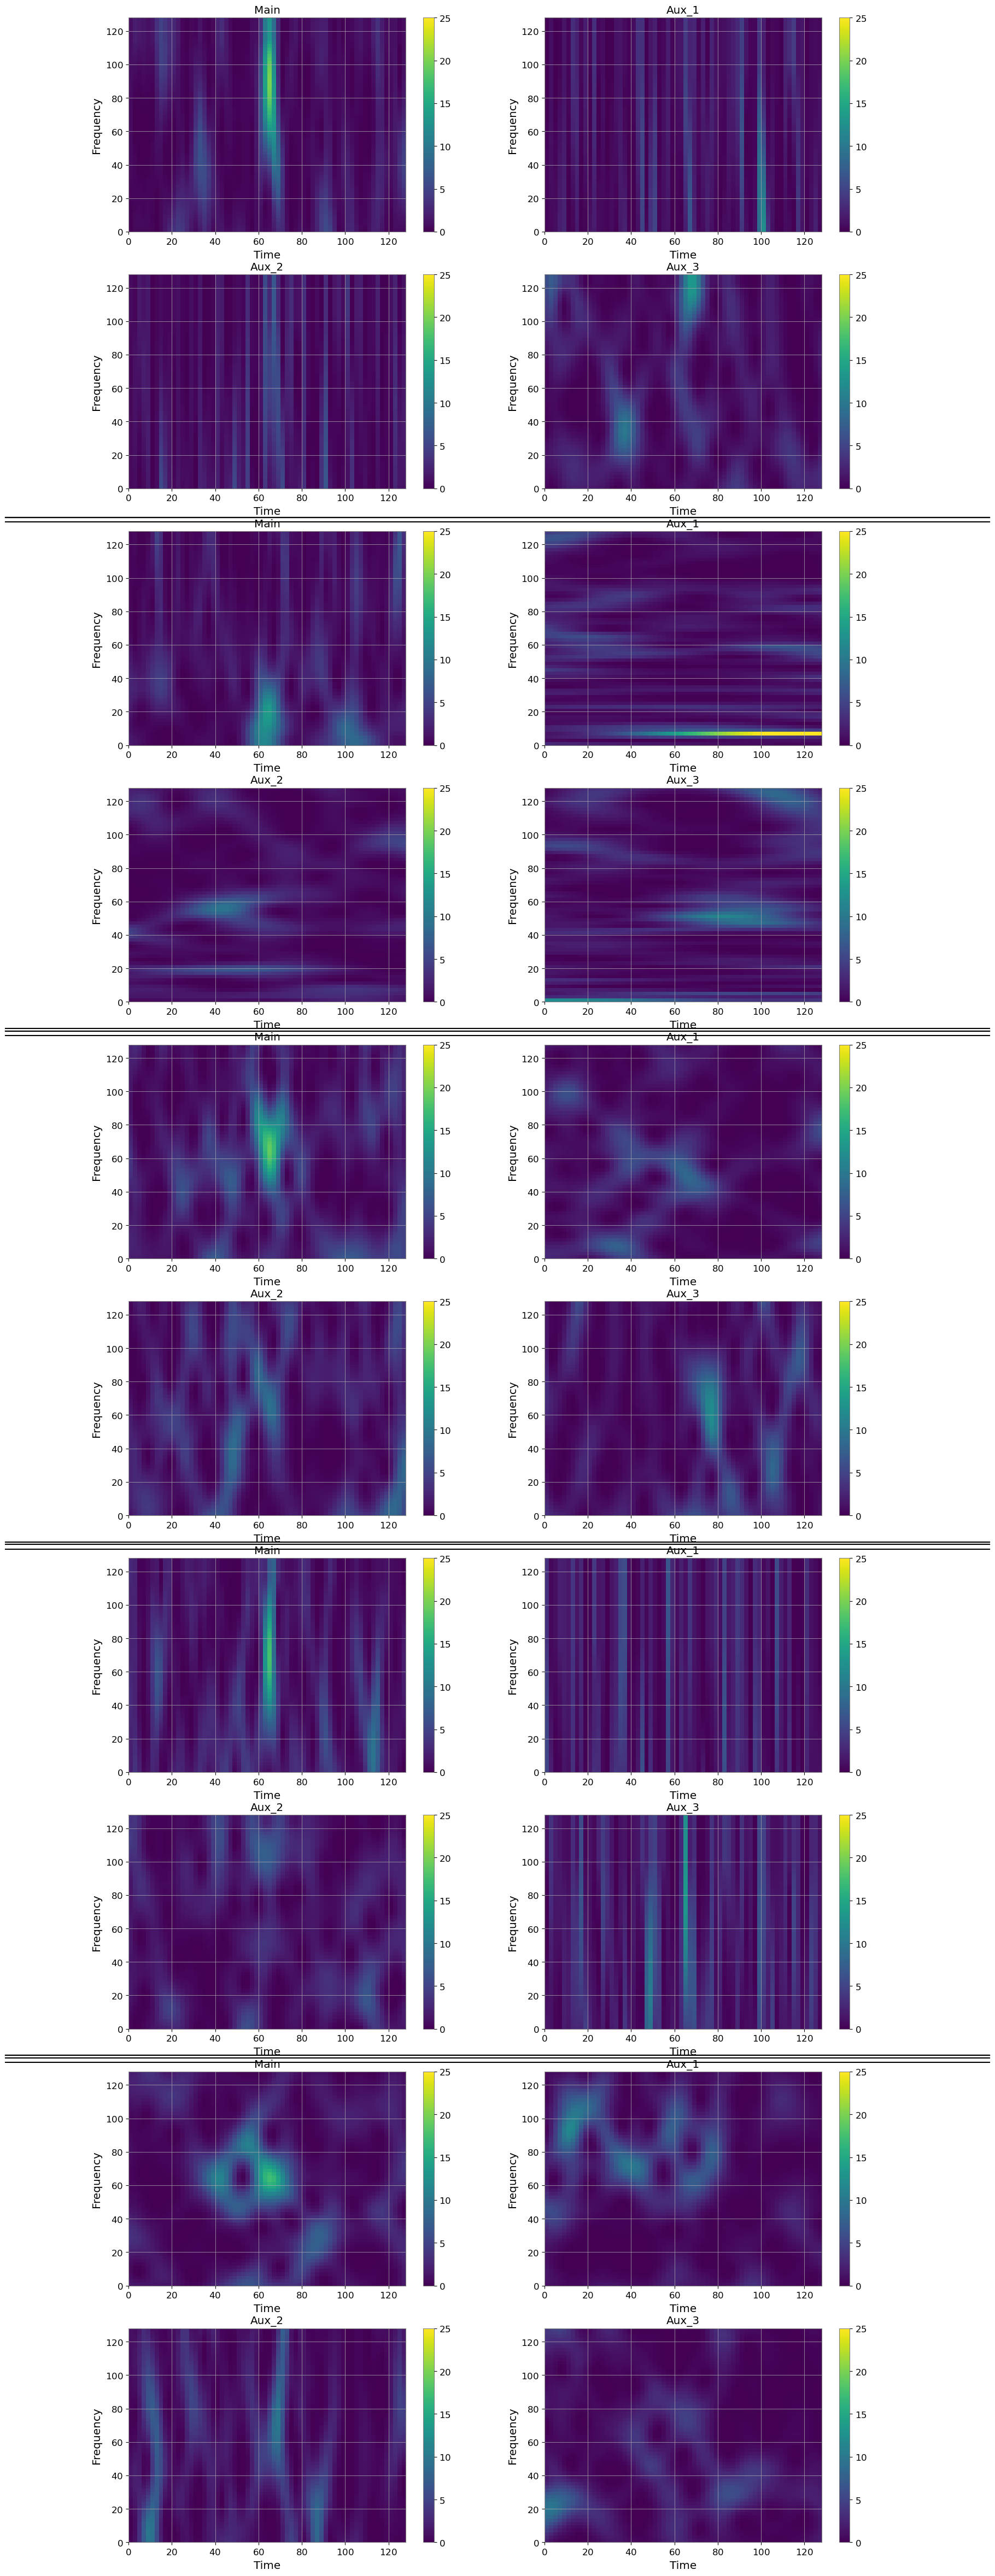

In [92]:
show_dataset(df,128,5)

In [93]:
#save dataset
save_name='Image_dataset_synthetic_64x64.pkl'
df.to_pickle(save_name)

# Preprocess Data

In this section we prepare the dataset for NN training and inference.

The section is divided in two parts:
- 1) **Split Data**, where we convert the dataset to torch, and then divide it into train and test set (making also a smaller version of the two)
- 2) **Normalise Data & Dataloader**, where we bring the dataset to the range [0,1] (for NN convergence reasons) and create dataloader objects

### Split Data

In [11]:
#Load data from .pkl
file_path='Image_dataset_synthetic_64x64.pkl'
df = pd.read_pickle(file_path)

In [94]:
#Convert data to torch
df = df.applymap(lambda x: torch.tensor(x))

#Devide Image dataset in main and aux channels. Note that df generated in the section Generate Synthetic Dataset will always have the main channel as its first column
main_channel=list(df.columns)[0]
aux_channels=list(df.columns)[1:]

df_aux_all_2d = pd.DataFrame(df[aux_channels])
df_main_all_2d = pd.DataFrame(df[main_channel])

In [95]:
X_train_2d, X_test_2d, y_train_2d, y_test_2d = train_test_split(df_aux_all_2d, df_main_all_2d, test_size=0.1, random_state=42)

# TRAINING SET

#smaller dataset
signal_data_train_small_2d = torch.stack([torch.stack([y_train_2d[main_channel].iloc[i]]) for i in range(100)]) #for i in range(y_train.shape[0])
aux_data_train_small_2d = torch.stack([torch.stack([X_train_2d.iloc[i][0], X_train_2d.iloc[i][1], X_train_2d.iloc[i][2]]) for i in range(100)]) #for i in range(X_train.shape[0])


#whole dataset
signal_data_train_2d = torch.stack([torch.stack([y_train_2d[main_channel].iloc[i]]) for i in range(y_train_2d.shape[0])]) #
aux_data_train_2d = torch.stack([torch.stack([X_train_2d.iloc[i][0], X_train_2d.iloc[i][1], X_train_2d.iloc[i][2]]) for i in range(X_train_2d.shape[0])]) #


#concatenate torch.tensors
train_data_2d=torch.cat([signal_data_train_2d,aux_data_train_2d],dim=1) 
train_data_small_2d=torch.cat([signal_data_train_small_2d,aux_data_train_small_2d],dim=1) 

print(signal_data_train_2d.shape)
print(aux_data_train_2d.shape)
#--------------------------------------------

# TEST SET

#smaller dataset
signal_data_test_small_2d = torch.stack([torch.stack([y_test_2d[main_channel].iloc[i]]) for i in range(100)]) #for i in range(y_test.shape[0])
aux_data_test_small_2d = torch.stack([torch.stack([X_test_2d.iloc[i][0], X_test_2d.iloc[i][1], X_test_2d.iloc[i][2]]) for i in range(100) ]) #for i in range(X_test.shape[0])

#whole dataset
signal_data_test_2d = torch.stack([torch.stack([y_test_2d[main_channel].iloc[i]]) for i in range(y_test_2d.shape[0])]) #
aux_data_test_2d = torch.stack([torch.stack([X_test_2d.iloc[i][0], X_test_2d.iloc[i][1], X_test_2d.iloc[i][2]]) for i in range(X_test_2d.shape[0]) ]) #

test_data_2d = torch.cat([signal_data_test_2d, aux_data_test_2d], dim=1) 
test_data_small_2d = torch.cat([signal_data_test_small_2d, aux_data_test_small_2d], dim=1) 

print(signal_data_test_2d.shape)
print(aux_data_test_2d.shape)
#-----------------------------------------------

torch.Size([900, 1, 64, 64])
torch.Size([900, 3, 64, 64])
torch.Size([100, 1, 64, 64])
torch.Size([100, 3, 64, 64])


In [96]:
batch_size = 20

### Normalise Data & Dataloader

In [97]:
def normalize_(data,chan=4):
    print(data.shape)
    """
    Normalizes the qplot data to the range [0,1] for NN convergence purposes
    
    Input:
    - data (torch.Tensor) : dataset of qtransforms
    - chan (int) : number of channels in dataset (default 4)
    
    Return:
    - data (torch.tensor) : normalized dataset
    """
    max_vals = data.view(data.shape[0], data.shape[1], -1).max(0)[0].max(1)[0]  # Compute the maximum value for each channel across all 900 tensors
    print("Maximum values for each channel across all tensors:", max_vals, max_vals.shape)
    data /= max_vals.view(1, chan, 1, 1)  # Divide each element by the maximum value of its channel
    return data

In [98]:
train_data_2d=normalize_(train_data_2d)

torch.Size([900, 4, 64, 64])
Maximum values for each channel across all tensors: tensor([34.2085, 26.7005, 27.7535, 30.1514]) torch.Size([4])


In [99]:
test_data_2d=normalize_(test_data_2d)


torch.Size([100, 4, 64, 64])
Maximum values for each channel across all tensors: tensor([36.4533, 20.6241, 22.9817, 26.7495]) torch.Size([4])


Visualise Normalised data

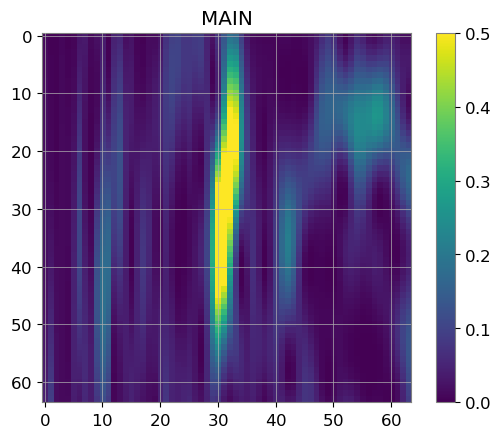

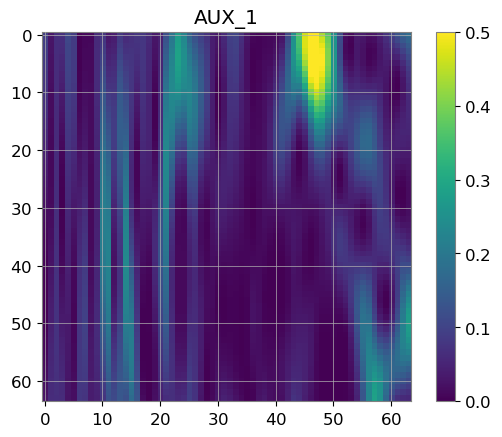

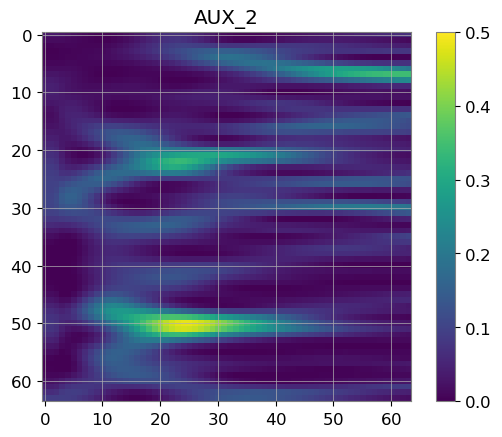

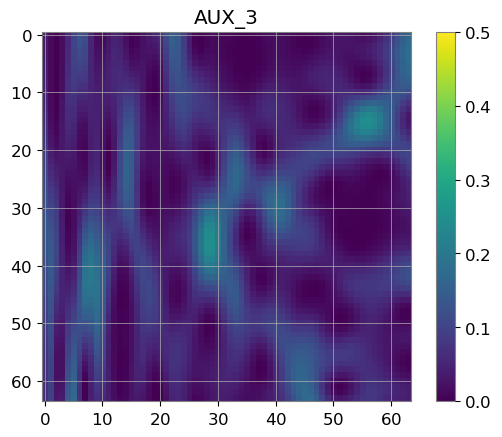

In [100]:
plt_number=18
plt.imshow(train_data_2d[plt_number,0],vmin=0,vmax=0.5)
plt.title('MAIN')
plt.colorbar()
plt.show()
plt.imshow(train_data_2d[plt_number,1],vmin=0,vmax=0.5)
plt.title('AUX_1')
plt.colorbar()
plt.show()
plt.imshow(train_data_2d[plt_number,2],vmin=0,vmax=0.5)
plt.title('AUX_2')
plt.colorbar()
plt.show()
plt.imshow(train_data_2d[plt_number,3],vmin=0,vmax=0.5)
plt.title('AUX_3')
plt.colorbar()
plt.show()

In [101]:
#Create dataloader objects with preprocessed dataset

dataloader = DataLoader(
    train_data_2d,
    batch_size=batch_size,
    shuffle=True,
)


test_dataloader = DataLoader(
    test_data_2d,
    batch_size=batch_size,
    shuffle=False,
)

# NN Models

In this section we define different NN architectures models, and initialise one of them as the generator to use in training and inference.

This section is split in three parts:
- 1) **Weight Initialization**, where we define the function to initialise the weights of the NN models according to certain parameters and distributions passed as input
- 2) **NN Models**, where we define different NN models exploting different architecutres
- 3) **Generator**, where we initialise one of the above models as the generator to use in training and inference

## Weight Initialization

In [102]:
def init_weights(net, init_type='normal', scaling=0.02):
    """
    Initialize the weights of the neural network according to the specified initialization type.

    Parameters:
        - net (nn.Module): The neural network model.
        - init_type (str): Type of initialization. Options: 'normal', 'xavier' (default is 'normal').
        - scaling (float): Scaling factor for weight initialization (default is 0.02).
    """
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv')) != -1:
            torch.nn.init.normal_(m.weight.data, 0.0, scaling)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            torch.nn.init.normal_(m.weight.data, 1.0, scaling)
            torch.nn.init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function 

## Model definition

In this section we define a few different NN model architectures. They can all be used for training and inference.

#### DEEPER DECODER

In [185]:
#DEEPER DECODER
class Decoder_2d_deep(nn.Module):
    """
    Deep 2D decoder network.

    Args:
        - in_channels (int): Number of input channels.
        - kernel_size (int): Size of the convolutional kernel (default is 5).
    """

    def __init__(self, in_channels, kernel_size=5):
        super(Decoder_2d_deep, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=kernel_size, stride=1, padding=kernel_size // 2)
        self.relu1 = nn.LeakyReLU(0.3, inplace=True)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=kernel_size, stride=1, padding=kernel_size // 2)
        self.relu2 = nn.LeakyReLU(0.3, inplace=True)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=kernel_size, stride=1, padding=kernel_size // 2)
        self.relu3 = nn.LeakyReLU(0.3, inplace=True)

        self.conv4 = nn.Conv2d(256, 1, kernel_size=kernel_size, stride=1, padding=kernel_size // 2)
        if norm:
            self.activation = torch.nn.Sigmoid()
        else:
            self.activation = torch.nn.ReLU()

    def _forward_features(self, x):
        """
        Perform forward pass through the network layers.

        Args:
            - x (torch.Tensor): Input tensor.

        Returns:
            - torch.Tensor: Output tensor.
        """
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))
        x = self.conv4(x)
        x = self.activation(x)
        return x

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
            - x (torch.Tensor): Input tensor.

        Returns:
            - torch.Tensor: Output tensor.
        """
        return self._forward_features(x)


#### SHALLOW DECODER

In [103]:
#SHALLOW DECODER
class Decoder(nn.Module):
    """
    Decoder network.

    Args:
        - in_channels (int): Number of input channels.
        - kernel_size (int): Size of the convolutional kernel (default is 7).
        - a (float): Scaling factor (default is 80.0).
        - norm (bool): Whether to apply normalization (default is True).
    """

    def __init__(self, in_channels, kernel_size=7, norm=True):
        super(Decoder, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=kernel_size, stride=1, padding=kernel_size // 2)
        self.relu1 = nn.LeakyReLU(0.2, inplace=True)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, stride=1, padding=kernel_size // 2)
        self.relu2 = nn.LeakyReLU(0.2, inplace=True)

        self.conv3 = nn.Conv2d(64, 64, kernel_size=kernel_size, stride=1, padding=kernel_size // 2)
        self.relu3 = nn.LeakyReLU(0.2, inplace=True)

        self.conv4 = nn.Conv2d(64, 1, kernel_size=kernel_size, stride=1, padding=kernel_size // 2)

        if norm:
            self.activation = torch.nn.Sigmoid()
        else:
            self.activation = torch.nn.ReLU()

    def _forward_features(self, x):
        """
        Perform forward pass through the network layers.

        Args:
            - x (torch.Tensor): Input tensor.

        Returns:
            - torch.Tensor: Output tensor.
        """
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))
        x = self.conv4(x)
        x = self.activation(x)
        return x

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
            - x (torch.Tensor): Input tensor.

        Returns:
            - torch.Tensor: Output tensor.
        """
        return self._forward_features(x)


#### GENERAL DECODER (NOT USED IN THIS VERSION OF THE NOTEBOOK)

In [32]:
#More general convolutional network (decoder style). Not used in current veriwon of notebook, but can be used to generalise Decoder and decoder_2d_deep

def make_conv_net(hidden_sizes, kernel_size, in_channels, out_channels,bn,drop,activation='leaky'):
    '''
    Convolutionaal Neural Netowrk
    hiddens_sizes=[N_filters for hidden layer 1, .... ,N_filters for hidden layer n]
    num hidden layers = len(hidden_sizes)
    kernel_size= kernel size for layer i (included output layer)
    bn = add batch normalization after layer i if bn[i]==True
    drop= add dropout with p=drop[i] if drop[i]!= None/False
    dilation = dilation[i] dilation for layer i (included output)
    activatio: choose one of leaky (leakyrelu), tanh, relu, gelu
    '''
    sizes = [in_channels] + hidden_sizes + [out_channels]
    net = []
    for i in range(len(sizes) - 1):
        conv = torch.nn.Conv2d(sizes[i], sizes[i+1], kernel_size[i], padding=kernel_size[i]//2, stride=1, padding_mode='zeros',dilation=1)
        net.append(conv)
        if i != len(sizes) - 2:
            if bn[i]:
                net.append(nn.BatchNorm2d(sizes[i+1]))
            if drop[i]:
                net.append(nn.Dropout(p=drop[i]))
            if activation=="leaky":
                net.append(torch.nn.LeakyReLU(0.2))
            elif activation=="tanh":
                net.append(torch.nn.Tanh())
            elif activation=='relu':
                net.append(torch.nn.ReLU())
            elif activation == 'gelu':
                net.append(nn.GELU())
            
    return torch.nn.Sequential(*net)

#### RESNET

In [186]:
#RESNET
class ResidualBlock(nn.Module):
    """
    Residual block module.

    Args:
        - in_features (int): Number of input features/channels.
    """

    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        # Define the block sequence
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),  # Pads the input tensor using the reflection of the input boundary
            nn.Conv2d(in_features, in_features, 3),  # 2D convolutional layer
            nn.InstanceNorm2d(in_features),  # Instance normalization
            nn.ReLU(inplace=True),  # ReLU activation function
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        """
        Forward pass through the residual block.

        Args:
            - x (torch.Tensor): Input tensor.

        Returns:
            - torch.Tensor: Output tensor.
        """
        return x + self.block(x)


class GeneratorResNet(nn.Module):
    """
    Generator network using ResNet architecture.

    Args:
        - input_shape (int): Number of input features/channels.
        - num_residual_block (int): Number of residual blocks.
        - output_shape (int): Number of output features/channels.
    """

    def __init__(self, input_shape, num_residual_block, output_shape, norm=False):
        super(GeneratorResNet, self).__init__()

        channels = input_shape
        target_channels = output_shape
        # Initial Convolution Block
        out_features = 64
        if norm:
            self.final_activation = torch.nn.Sigmoid()
        else:
            self.final_activation = torch.nn.ReLU()
            
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True)
        ]
        in_features = out_features

        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_block):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2),  # Upsampling layer
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features

        # Output Layer
        model += [nn.ReflectionPad2d(target_channels),
                  nn.Conv2d(out_features, target_channels, 3),
                  nn.final_activation()  # Sigmoid activation function
                  ]

        # Unpacking
        self.model = nn.Sequential(*model)

    def forward(self, x):
        """
        Forward pass through the generator network.

        Args:
            - x (torch.Tensor): Input tensor.

        Returns:
            - torch.Tensor: Output tensor.
        """
        return self.model(x)


#### UNET

In [145]:
#UNET
import torch
import torch.nn as nn

class Conv2dBlock(nn.Module):
    """
    Convolutional block module.

    Args:
        - in_channels (int): Number of input channels.
        - out_channels (int): Number of output channels.
        - kernel_size (int): Size of the convolutional kernel (default is 3).
    """

    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(Conv2dBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=1)
        self.activation = nn.ReLU()

    def forward(self, x):
        """
        Forward pass through the convolutional block.

        Args:
            - x (torch.Tensor): Input tensor.

        Returns:
            - torch.Tensor: Output tensor.
        """
        x = self.conv1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.activation(x)
        return x

class EncoderBlock(nn.Module):
    """
    Encoder block module.

    Args:
        - in_channels (int): Number of input channels.
        - out_channels (int): Number of output channels.
        - pool_size (tuple): Size of the pooling kernel (default is (2, 2)).
        - dropout (float): Dropout rate (default is 0.3).
    """

    def __init__(self, in_channels, out_channels, pool_size=(2, 2), dropout=0.3):
        super(EncoderBlock, self).__init__()
        self.conv_block = Conv2dBlock(in_channels, out_channels)
        self.maxpool = nn.MaxPool2d(pool_size)
        self.dropout = nn.Dropout2d(dropout)

    def forward(self, x):
        """
        Forward pass through the encoder block.

        Args:
            - x (torch.Tensor): Input tensor.

        Returns:
            - torch.Tensor: Output tensor.
        """
        features = self.conv_block(x)
        pooled = self.maxpool(features)
        pooled = self.dropout(pooled)
        return features, pooled

class Encoder(nn.Module):
    """
    Encoder network module.

    Args:
        - input_channels (int): Number of input channels.
    """

    def __init__(self, input_channels):
        super(Encoder, self).__init__()
        self.block1 = EncoderBlock(input_channels, 64)
        self.block2 = EncoderBlock(64, 128)
        self.block3 = EncoderBlock(128, 256)
        self.block4 = EncoderBlock(256, 512)

    def forward(self, x):
        """
        Forward pass through the encoder network.

        Args:
            - x (torch.Tensor): Input tensor.

        Returns:
            - torch.Tensor: Output tensor.
        """
        f1, p1 = self.block1(x)
        f2, p2 = self.block2(p1)
        f3, p3 = self.block3(p2)
        f4, p4 = self.block4(p3)
        return p4, (f1, f2, f3, f4)

class Bottleneck(nn.Module):
    """
    Bottleneck module.

    """

    def __init__(self):
        super(Bottleneck, self).__init__()
        self.conv_block = Conv2dBlock(512, 1024)

    def forward(self, x):
        """
        Forward pass through the bottleneck module.

        Args:
            - x (torch.Tensor): Input tensor.

        Returns:
            - torch.Tensor: Output tensor.
        """
        return self.conv_block(x)

class DecoderBlock(nn.Module):
    """
    Decoder block module.

    Args:
        - in_channels (int): Number of input channels.
        - out_channels (int): Number of output channels.
        - kernel_size (int): Size of the convolutional kernel (default is 3).
        - stride (int): Stride size for the convolutional operation (default is 2).
        - dropout (float): Dropout rate (default is 0.3).
    """

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, dropout=0.3):
        super(DecoderBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, padding=1, output_padding=1)
        self.dropout = nn.Dropout2d(dropout)
        self.conv_block = Conv2dBlock(out_channels * 2, out_channels)

    def forward(self, x, conv_output):
        """
        Forward pass through the decoder block.

        Args:
            - x (torch.Tensor): Input tensor.
            - conv_output (torch.Tensor): Output tensor from the corresponding encoder block.

        Returns:
            - torch.Tensor: Output tensor.
        """
        x = self.deconv(x, output_size=conv_output.size())
        x = torch.cat([x, conv_output], dim=1)
        x = self.dropout(x)
        x = self.conv_block(x)
        return x

class Decoder(nn.Module):
    """
    Decoder network module.

    Args:
        - output_channels (int): Number of output channels.
    """

    def __init__(self, output_channels):
        super(Decoder, self).__init__()
        self.block6 = DecoderBlock(1024, 512)
        self.block7 = DecoderBlock(512, 256)
        self.block8 = DecoderBlock(256, 128)
        self.block9 = DecoderBlock(128, 64)
        self.final_conv = nn.Conv2d(64, output_channels, kernel_size=1)
        

    def forward(self, x, convs):
        """
        Forward pass through the decoder network.

        Args:
            - x (torch.Tensor): Input tensor.
            - convs (tuple): Tuple containing the output tensors from the encoder blocks.

        Returns:
            - torch.Tensor: Output tensor.
        """
        f1, f2, f3, f4 = convs
        x = self.block6(x, f4)
        x = self.block7(x, f3)
        x = self.block8(x, f2)
        x = self.block9(x, f1)
        outputs = self.final_conv(x)
        
        return outputs

class UNet(nn.Module):
    """
    UNet network module.

    Args:
        - input_channels (int): Number of input channels.
        - output_channels (int): Number of output channels.
    """

    def __init__(self, input_channels=3, output_channels=1,norm=True):
        super(UNet, self).__init__()
        self.encoder = Encoder(input_channels)
        self.bottleneck = Bottleneck()
        self.decoder = Decoder(output_channels)
        if norm:
            self.final_activation = torch.nn.Sigmoid()
        else:
            self.final_activation = torch.nn.ReLU()


    def forward(self, x):
        """
        Forward pass through the UNet network.

        Args:
            - x (torch.Tensor): Input tensor.

        Returns:
            - torch.Tensor: Output tensor.
        """
        encoder_output, convs = self.encoder(x)
        bottleneck_output = self.bottleneck(encoder_output)
        outputs = self.decoder(bottleneck_output, convs)
        return self.final_activation(outputs)


## Generator

Choose one of the following NN Models

In [ ]:
# DEEPER DECODER
try:
    del generator_2d
    print('generator_2d deleted')
except:
    pass
generator_2d=Decoder_2d_deep(3).to(device)
init_weights(generator_2d, 'normal', scaling=.02)
print(generator_2d)

In [123]:
# SHALLOW DECODER
try:
    del generator_2d
    print('generator_2d deleted')
except:
    pass
generator_2d=Decoder(3,norm=False).to(device)
init_weights(generator_2d, 'normal', scaling=.02)
print(generator_2d)

generator_2d deleted
initialize network with normal
Decoder(
  (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (relu1): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (relu2): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv3): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (relu3): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv4): Conv2d(64, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (activation): ReLU()
)


In [ ]:
# RESNET
try:
    del generator_2d
    print('generator_2d deleted')
except:
    pass
generator_2d=GeneratorResNet(3,12,1).to(device)
init_weights(generator_2d, 'normal', scaling=0.01)
print(generator_2d)

In [163]:
#UNET

input_channels=3
output_channels=1

try:
    del generator_2d
    print('generator deleted')
except:
    pass


generator_2d = UNet(input_channels, output_channels,False).to(device)
init_weights(generator_2d, 'normal', scaling=.02)
print(generator_2d)

generator deleted
initialize network with normal
UNet(
  (encoder): Encoder(
    (block1): EncoderBlock(
      (conv_block): Conv2dBlock(
        (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (dropout): Dropout2d(p=0.3, inplace=False)
    )
    (block2): EncoderBlock(
      (conv_block): Conv2dBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (dropout): Dropout2d(p=0.3, inplace=False)
    )
    (block3): EncoderBlock(
      (conv_block): Conv2dBlock(
        (conv1): C

In [ ]:
'''#General CNN
hidden_sizes=[64,128,256] #Numero di kernel per hidden layer
kernels=[3,3,3,3] #dimensione dei kernel per ogni layer (compreso l'output)
bn=[True,True,True] #True -> Batch Normalization nel hidden layer corrispondente
drop=[0.3,0.3,0.3] # Dropout with p[i]=drop[i]
generator=make_conv_net(hidden_sizes, kernels, 3, 1,bn,drop).to(device)
init_weights(generator, 'normal', scaling=0.005)
print(generator)
'''

# Training

In this section, we train the previously defined and initialised NN model.

This section is divided into three parts:
- 1) **Functions**, which contains utils functions to calculate several loss functions for the networks, a metric for accuracy (not used in the current version of the notebook) a function to make inference and a function to train the model and save the weights
- 2) **Pre-training generation**, where we make inference on test data using untrained network
- 3) **Actual training**, where we train the NN, save the weigths and plot losses curves

### Functions

In [105]:
# Metric function: IOU Not used in this version of the notebook

def calculate_iou_2d(generated, target, threshold):
    """
    Calculate Intersection over Union (IoU) in the 2D plane at the specified intensity threshold.

    Parameters:
    - generated: List of time series representing the generated spectrograms
    - target: List of time series representing the target spectrograms
    - threshold: Intensity threshold for determining the binary masks

    Returns:
    - IoU: Intersection over Union
    """
    # Extract spectrogram values from time series
    # print(generated[0][0])
    # print(generated[0][0].shape)
    # print(type(generated[0][0]))
    
    
    spectrograms_gen = [TimeSeries(t[0], dt=1/4096.0).q_transform(frange=(10, 1000)).value for t in generated]
    spectrograms_real = [TimeSeries(t[0], dt=1/4096.0).q_transform(frange=(10, 1000)).value for t in target]

    # Create binary masks based on the intensity threshold
    mask1 = [spectrogram >= threshold for spectrogram in spectrograms_gen]
    mask2 = [spectrogram >= threshold for spectrogram in spectrograms_real]

    # Calculate the intersection and union of the binary masks
    intersection = [np.logical_and(m1, m2) for m1, m2 in zip(mask1, mask2)]
    union = [np.logical_or(m1, m2) for m1, m2 in zip(mask1, mask2)]

    # Calculate Intersection over Union (IoU)
    iou_list = np.array([np.sum(inter) / np.sum(uni) for inter, uni in zip(intersection, union)])

    iou = iou_list.mean()
    return iou


In [106]:
# utils function to generate data using the decoder for inference 
def generate_data(generator, batch, normalize=True):
    """
    Generate data using a generator model.

    Args:
        - generator (nn.Module): Generator model.
        - batch (torch.Tensor): Input batch data.
        - normalize (bool): Flag indicating whether to normalize the generated data (default is False).

    Returns:
        - torch.Tensor: Generated data.
    """
    target = batch[:, 0].unsqueeze(1).to(device)
    input = batch[:, 1:].to(device)
    with torch.no_grad():
        generated = generator(input.float())
        if normalize:
            print(generated.shape)
            generated = normalize_(generated, 1)

    return generated


In [107]:
#more sophisticated loss function

def log_cosh_loss(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    def _log_cosh(x: torch.Tensor) -> torch.Tensor:
        return x + torch.nn.functional.softplus(-2. * x) - math.log(2.0)
    return torch.mean(_log_cosh(y_pred - y_true))

class LogCoshLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(
        self, y_pred: torch.Tensor, y_true: torch.Tensor
    ) -> torch.Tensor:
        return log_cosh_loss(y_pred, y_true)



In [108]:
def train_decoder(num_epochs,generator,criterion,optimizer,dataloader,val_loader,accuracy,checkpoint_path, save_best=True):
    # num_epochs: (int) number of epochs for training
    # generator: (NN.Module) NN model to train
    # criterion: (torch.optim) optimiser to use in training
    # dataloader: (DataLoader) training data
    # val_loader: (Dataloader) validation data
    # accuracy: (function) metric to measure performance of the model (Note not to be confused with loss)
    # checkpoint_path: (str) full path (including filename in the form filename_{}.pkl so to insert num_epoch) to save checkpoints at
    # save_best: (bool) if you want to save best performing model
    
    
    #uncomment all lines relative to accuracy if you want to measure IOU between generated and real spectrograms.
    #Note that it significantly slows down the whole process
    # it also might not work as the function has not been fully implemented yet
    
    loss_plot =[]
    val_loss_plot =[]
    acc_plot=[]
    val_acc_plot=[]
    best_val_loss=5000000
    for epoch in tqdm(range(1,num_epochs+1)):
        st=time.time()
        epoch_loss =[]
        epoch_acc=[]
        for i, batch in enumerate(dataloader):
            #batch= transform(batch)
            target = batch[:,0].unsqueeze(1).to(device)
            #print(f'TARGET ON DEVICE: {target.get_device()}')
            target=target.float()
            input = batch[:,1:].to(device)
            #print(f'INPUT ON DEVICE: {input.get_device()}')
            
            optimizer.zero_grad()
            generated = generator(input.float())
            #generated=normalize_(generated,1)
            loss=criterion(generated,target)
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.detach().cpu().numpy())
            #acc=accuracy(generated.detach().cpu().numpy(),target.detach().cpu().numpy(),20)
            #epoch_acc.append(acc)
        val_loss =[]
        val_acc=[]
        for batch in(val_loader):
            #batch= transform(batch)
            target = batch[:,0].unsqueeze(1).to(device)
            target=target.float()
            input = batch[:,1:].to(device)
            with torch.no_grad():
                generated = generator(input.float())
                #generated=normalize_(generated,1)
                loss=criterion(generated,target)
                val_loss.append(loss.detach().cpu().numpy())
                #acc=accuracy(generated.detach().cpu().numpy(),target.detach().cpu().numpy(),20)
                #val_acc.append(acc)
        loss_plot.append(np.mean(epoch_loss))
        val_loss_plot.append(np.mean(val_loss))
        acc_plot.append(np.mean(epoch_acc))
        val_acc_plot.append(np.mean(val_acc))
        #print('epoch: {} loss: {} val loss: {} accuracy: {} val accuracy: {}'.format(epoch,loss_plot[-1],val_loss_plot[-1],acc_plot[-1],val_acc_plot[-1]))
        et=time.time()
        print('epoch: {} loss: {} val loss: {} time:{}s'.format(epoch,loss_plot[-1],val_loss_plot[-1],et-st))
        
        # Save checkpoint every 100 epochs
        if (epoch+1) % 100 == 0:
            #uncomment the following if you want to save checkpoint every 100 epochs regardless of the performance of the model
            # checkpoint = {
            #     'epoch': epoch,
            #     'model_state_dict': generator.state_dict(),
            #     'optimizer_state_dict': optimizer.state_dict(),
            #     'loss': loss_plot[-1],
            #     'val_loss': val_loss_plot[-1],
            # }
            
            # checkpoint_filename = checkpoint_path.format(epoch)
            # torch.save(checkpoint, checkpoint_filename)
            
            if save_best and val_loss_plot[-1] < best_val_loss: # instead of val_loss and best_val loss we should use accuracy!!!
                #create checkpoint
                checkpoint = {
                'epoch': epoch,
                'model_state_dict': generator.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_plot[-1],
                'val_loss': val_loss_plot[-1],
                }
                
                #save checkpoint only if it is better than the previous ones
                checkpoint_filename = checkpoint_path.format(epoch)
                torch.save(checkpoint, checkpoint_filename)
                
                #update best model
                best_val_loss = val_loss_plot[-1]
                best_checkpoint_filename = checkpoint_path.format('best')
                torch.save(checkpoint, best_checkpoint_filename)
        
        
    return loss_plot, val_loss_plot,acc_plot, val_acc_plot #,acc_plot, val_acc_plot,

### Pre-training generation

In [164]:
for batch in(tqdm(test_dataloader)):
    generated=generate_data(generator_2d,batch,normalize=True)
    break
generated[1,0].shape
#batch=transform(batch)

  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([20, 1, 64, 64])
torch.Size([20, 1, 64, 64])
Maximum values for each channel across all tensors: tensor([0.0068], device='cuda:0') torch.Size([1])


torch.Size([64, 64])

In [165]:
qplt_g=generated[1,0].detach().cpu().numpy()
qplt_r=batch[1,0].detach().cpu().numpy()

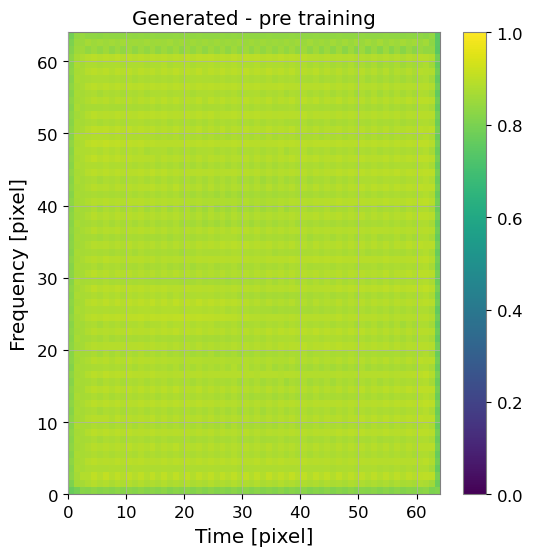

In [166]:
plt.figure(figsize=(6, 6))
plt.imshow(qplt_g, aspect='auto', extent=[0, 64, 0,64],vmin=0,vmax=1)
plt.title('Generated - pre training')
plt.xlabel('Time [pixel]')
plt.ylabel('Frequency [pixel]')
plt.colorbar()
plt.show()

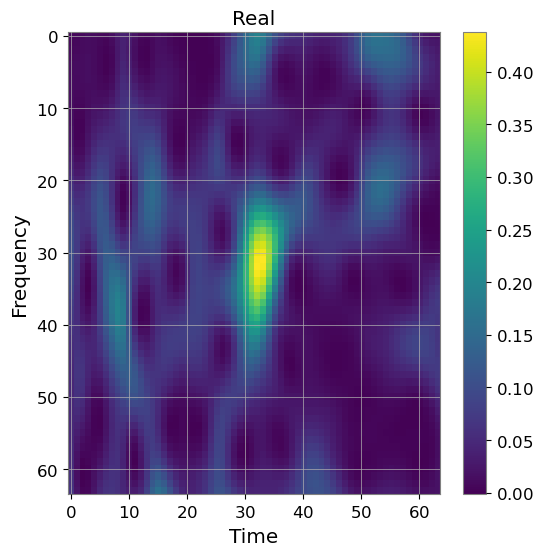

In [120]:
plt.figure(figsize= (6, 6))
plt.imshow(qplt_r, aspect='auto')
plt.title('Real')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()


In [ ]:
for i in range(generated.shape[0]):
    print('---------------------------')
    print(f'IMAGE {i}')
    qplt_g=generated[i,0].detach().cpu().numpy()
    qplt_r=batch[i,0].detach().cpu().numpy()
    
    plt.figure(figsize=(12, 4))
    plt.imshow(qplt_r, aspect='auto', extent=[0, 16/3, 10, 150])
    plt.title('Real ')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.colorbar()
    plt.show()
    
    plt.figure(figsize=(12, 4))
    plt.imshow(qplt_g, aspect='auto', extent=[0, 16/3, 10, 150],vmin=0,vmax=1)
    plt.title('Generated - pretraining')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.colorbar()
    plt.show()
    
    

### Actual training

In [171]:
# loss function, learning rate, and optimiser

l2_loss = nn.MSELoss() #this is l2!!!
l1_loss = nn.L1Loss()  #this is L1!!!
loss=l1_loss #LogCoshLoss()
lr=0.00005

G_optimizer = torch.optim.Adam(generator_2d.parameters(), lr=lr )

In [176]:
save_checkpoint='choose_your_path.checkpoint_epoch_{}.pth'
n_epochs=50

In [177]:
loss_plot, val_loss_plot,acc_plot, val_acc_plot=train_decoder(n_epochs,generator_2d,loss,G_optimizer,dataloader,test_dataloader,calculate_iou_2d,save_checkpoint)

  2%|▏         | 1/50 [00:00<00:33,  1.44it/s]

epoch: 1 loss: 0.03284371271729469 val loss: 0.03684006631374359 time:0.6926076412200928s


  4%|▍         | 2/50 [00:01<00:31,  1.53it/s]

epoch: 2 loss: 0.032688867300748825 val loss: 0.03583307936787605 time:0.6229767799377441s


  6%|▌         | 3/50 [00:01<00:30,  1.56it/s]

epoch: 3 loss: 0.03236646205186844 val loss: 0.03678594157099724 time:0.6286416053771973s


  8%|▊         | 4/50 [00:02<00:29,  1.57it/s]

epoch: 4 loss: 0.03213604912161827 val loss: 0.03636906296014786 time:0.627117395401001s


 10%|█         | 5/50 [00:03<00:28,  1.58it/s]

epoch: 5 loss: 0.03202604874968529 val loss: 0.037164125591516495 time:0.6270277500152588s


 12%|█▏        | 6/50 [00:03<00:27,  1.58it/s]

epoch: 6 loss: 0.031879328191280365 val loss: 0.03596347197890282 time:0.6274828910827637s


 14%|█▍        | 7/50 [00:04<00:27,  1.59it/s]

epoch: 7 loss: 0.03153695911169052 val loss: 0.0372655987739563 time:0.6278338432312012s


 16%|█▌        | 8/50 [00:05<00:26,  1.59it/s]

epoch: 8 loss: 0.03137987107038498 val loss: 0.03655184060335159 time:0.6285347938537598s


 18%|█▊        | 9/50 [00:05<00:25,  1.59it/s]

epoch: 9 loss: 0.031087234616279602 val loss: 0.035612113773822784 time:0.6286320686340332s


 20%|██        | 10/50 [00:06<00:25,  1.59it/s]

epoch: 10 loss: 0.030880339443683624 val loss: 0.036318860948085785 time:0.6298561096191406s


 22%|██▏       | 11/50 [00:06<00:24,  1.59it/s]

epoch: 11 loss: 0.03057602047920227 val loss: 0.036514170467853546 time:0.6297616958618164s


 24%|██▍       | 12/50 [00:07<00:23,  1.59it/s]

epoch: 12 loss: 0.03029828518629074 val loss: 0.036863625049591064 time:0.6293587684631348s


 26%|██▌       | 13/50 [00:08<00:23,  1.59it/s]

epoch: 13 loss: 0.02999678999185562 val loss: 0.03704153001308441 time:0.6290643215179443s


 28%|██▊       | 14/50 [00:08<00:22,  1.59it/s]

epoch: 14 loss: 0.029743647202849388 val loss: 0.03672889992594719 time:0.6297080516815186s


 30%|███       | 15/50 [00:09<00:22,  1.59it/s]

epoch: 15 loss: 0.029367661103606224 val loss: 0.03661220520734787 time:0.6304478645324707s


 32%|███▏      | 16/50 [00:10<00:21,  1.59it/s]

epoch: 16 loss: 0.029182495549321175 val loss: 0.037091150879859924 time:0.6311070919036865s


 34%|███▍      | 17/50 [00:10<00:20,  1.58it/s]

epoch: 17 loss: 0.02895025722682476 val loss: 0.03715468943119049 time:0.6309423446655273s


 36%|███▌      | 18/50 [00:11<00:20,  1.58it/s]

epoch: 18 loss: 0.028641413897275925 val loss: 0.03740131855010986 time:0.6308112144470215s


 38%|███▊      | 19/50 [00:12<00:19,  1.58it/s]

epoch: 19 loss: 0.028294701129198074 val loss: 0.0379207506775856 time:0.6316978931427002s


 40%|████      | 20/50 [00:12<00:18,  1.58it/s]

epoch: 20 loss: 0.02820424549281597 val loss: 0.03682922571897507 time:0.6314072608947754s


 42%|████▏     | 21/50 [00:13<00:18,  1.58it/s]

epoch: 21 loss: 0.027776893228292465 val loss: 0.03711666166782379 time:0.6314990520477295s


 44%|████▍     | 22/50 [00:13<00:17,  1.58it/s]

epoch: 22 loss: 0.02754308097064495 val loss: 0.03818443790078163 time:0.631537914276123s


 46%|████▌     | 23/50 [00:14<00:17,  1.58it/s]

epoch: 23 loss: 0.02725488319993019 val loss: 0.03829172998666763 time:0.6317522525787354s


 48%|████▊     | 24/50 [00:15<00:16,  1.58it/s]

epoch: 24 loss: 0.027004403993487358 val loss: 0.03852502256631851 time:0.6319751739501953s


 50%|█████     | 25/50 [00:15<00:15,  1.58it/s]

epoch: 25 loss: 0.026649978011846542 val loss: 0.03754498064517975 time:0.6330676078796387s


 52%|█████▏    | 26/50 [00:16<00:15,  1.58it/s]

epoch: 26 loss: 0.026514988392591476 val loss: 0.03765328601002693 time:0.6326920986175537s


 54%|█████▍    | 27/50 [00:17<00:14,  1.58it/s]

epoch: 27 loss: 0.02619824931025505 val loss: 0.03794560208916664 time:0.6325602531433105s


 56%|█████▌    | 28/50 [00:17<00:13,  1.58it/s]

epoch: 28 loss: 0.02601371891796589 val loss: 0.03849548101425171 time:0.6331632137298584s


 58%|█████▊    | 29/50 [00:18<00:13,  1.58it/s]

epoch: 29 loss: 0.025710269808769226 val loss: 0.0367954783141613 time:0.63393235206604s


 60%|██████    | 30/50 [00:18<00:12,  1.58it/s]

epoch: 30 loss: 0.025633342564105988 val loss: 0.03831378370523453 time:0.632533073425293s


 62%|██████▏   | 31/50 [00:19<00:12,  1.58it/s]

epoch: 31 loss: 0.025203241035342216 val loss: 0.038998305797576904 time:0.6339147090911865s


 64%|██████▍   | 32/50 [00:20<00:11,  1.58it/s]

epoch: 32 loss: 0.02504829317331314 val loss: 0.038865990936756134 time:0.633979320526123s


 66%|██████▌   | 33/50 [00:20<00:10,  1.58it/s]

epoch: 33 loss: 0.024654537439346313 val loss: 0.03818356990814209 time:0.6338193416595459s


 68%|██████▊   | 34/50 [00:21<00:10,  1.58it/s]

epoch: 34 loss: 0.02457476779818535 val loss: 0.0380006805062294 time:0.6340701580047607s


 70%|███████   | 35/50 [00:22<00:09,  1.58it/s]

epoch: 35 loss: 0.024326404556632042 val loss: 0.03807666152715683 time:0.6340539455413818s


 72%|███████▏  | 36/50 [00:22<00:08,  1.57it/s]

epoch: 36 loss: 0.02404828928411007 val loss: 0.039296410977840424 time:0.6358911991119385s


 74%|███████▍  | 37/50 [00:23<00:08,  1.58it/s]

epoch: 37 loss: 0.023798121139407158 val loss: 0.038571570068597794 time:0.6339874267578125s


 76%|███████▌  | 38/50 [00:24<00:07,  1.57it/s]

epoch: 38 loss: 0.023652195930480957 val loss: 0.038333822041749954 time:0.6348607540130615s


 78%|███████▊  | 39/50 [00:24<00:06,  1.57it/s]

epoch: 39 loss: 0.02333994396030903 val loss: 0.03857364505529404 time:0.6352436542510986s


 80%|████████  | 40/50 [00:25<00:06,  1.57it/s]

epoch: 40 loss: 0.023196840658783913 val loss: 0.038883280009031296 time:0.6339030265808105s


 82%|████████▏ | 41/50 [00:25<00:05,  1.57it/s]

epoch: 41 loss: 0.02298848330974579 val loss: 0.03889899700880051 time:0.6351780891418457s


 84%|████████▍ | 42/50 [00:26<00:05,  1.57it/s]

epoch: 42 loss: 0.02268950082361698 val loss: 0.03829788416624069 time:0.6351222991943359s


 86%|████████▌ | 43/50 [00:27<00:04,  1.57it/s]

epoch: 43 loss: 0.02257738634943962 val loss: 0.040169499814510345 time:0.6345057487487793s


 88%|████████▊ | 44/50 [00:27<00:03,  1.57it/s]

epoch: 44 loss: 0.02238345704972744 val loss: 0.039807479828596115 time:0.6340920925140381s


 90%|█████████ | 45/50 [00:28<00:03,  1.57it/s]

epoch: 45 loss: 0.022216858342289925 val loss: 0.0386369414627552 time:0.6344475746154785s


 92%|█████████▏| 46/50 [00:29<00:02,  1.57it/s]

epoch: 46 loss: 0.0220459196716547 val loss: 0.03998597711324692 time:0.6347980499267578s


 94%|█████████▍| 47/50 [00:29<00:01,  1.57it/s]

epoch: 47 loss: 0.02186649478971958 val loss: 0.03895582631230354 time:0.6347646713256836s


 96%|█████████▌| 48/50 [00:30<00:01,  1.57it/s]

epoch: 48 loss: 0.021683694794774055 val loss: 0.038695476949214935 time:0.6356058120727539s


 98%|█████████▊| 49/50 [00:31<00:00,  1.57it/s]

epoch: 49 loss: 0.02160009741783142 val loss: 0.03829013183712959 time:0.6351797580718994s


100%|██████████| 50/50 [00:31<00:00,  1.58it/s]

epoch: 50 loss: 0.021493293344974518 val loss: 0.0384337455034256 time:0.6366963386535645s


In [36]:
#save model in native PyTorch format (.pth or .pt)
torch.save(generator_2d.state_dict(), 'choose_your_path.pth')
print('Model saved')

Model saved


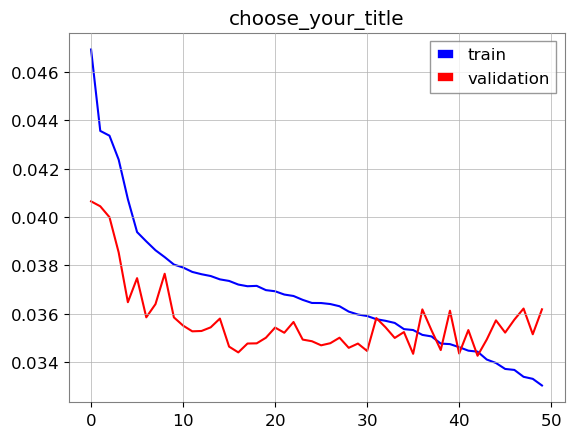

In [173]:
# Plotting the loss
import matplotlib.pyplot as plt
plt.plot(loss_plot,color='b',label='train')
plt.plot(val_loss_plot,color='r',label='validation')
plt.title('choose_your_title')
plt.legend()
#plt.savefig('lc.pdf')
#plt.yscale('log')
plt.show()

# Inference

In this section we make inference on test dataset using trained NN, and we plot the generated qplots.

This section is devided in two parts:
- 1) **Load Model**, where we load the model from checkpoint
- 2) **Actual Inferece**, where we generate data for main channel from the test dataset. We also plot the generated data and compare it to the target

#### Load Model

In [ ]:
# Define the path to your checkpoint file
checkpoint_path = '/home/jovyan/'

# Load the checkpoint
checkpoint = torch.load(checkpoint_path)

# Load the model state from the checkpoint
generator_2d.load_state_dict(checkpoint['model_state_dict']) # if this doesn't work try the commented line below

#load whole model
#generator_2d.load_state_dict(checkpoint) # if this doesn't work try the commented line above


In [ ]:
print(checkpoint.keys())

#### Actual Inference

In [178]:
#make inference on test data

for batch in(tqdm(test_dataloader)):
    generated_post=generate_data(generator_2d,batch,normalize=False)
    break
generated_post[0,0].shape

  0%|          | 0/5 [00:00<?, ?it/s]


torch.Size([64, 64])

In [134]:
qplt_g=generated_post[0,0].detach().cpu().numpy()
qplt_r=batch[0,0].detach().cpu().numpy()

Plot Real, Generated and input Qplots

---------------------------
IMAGE 0


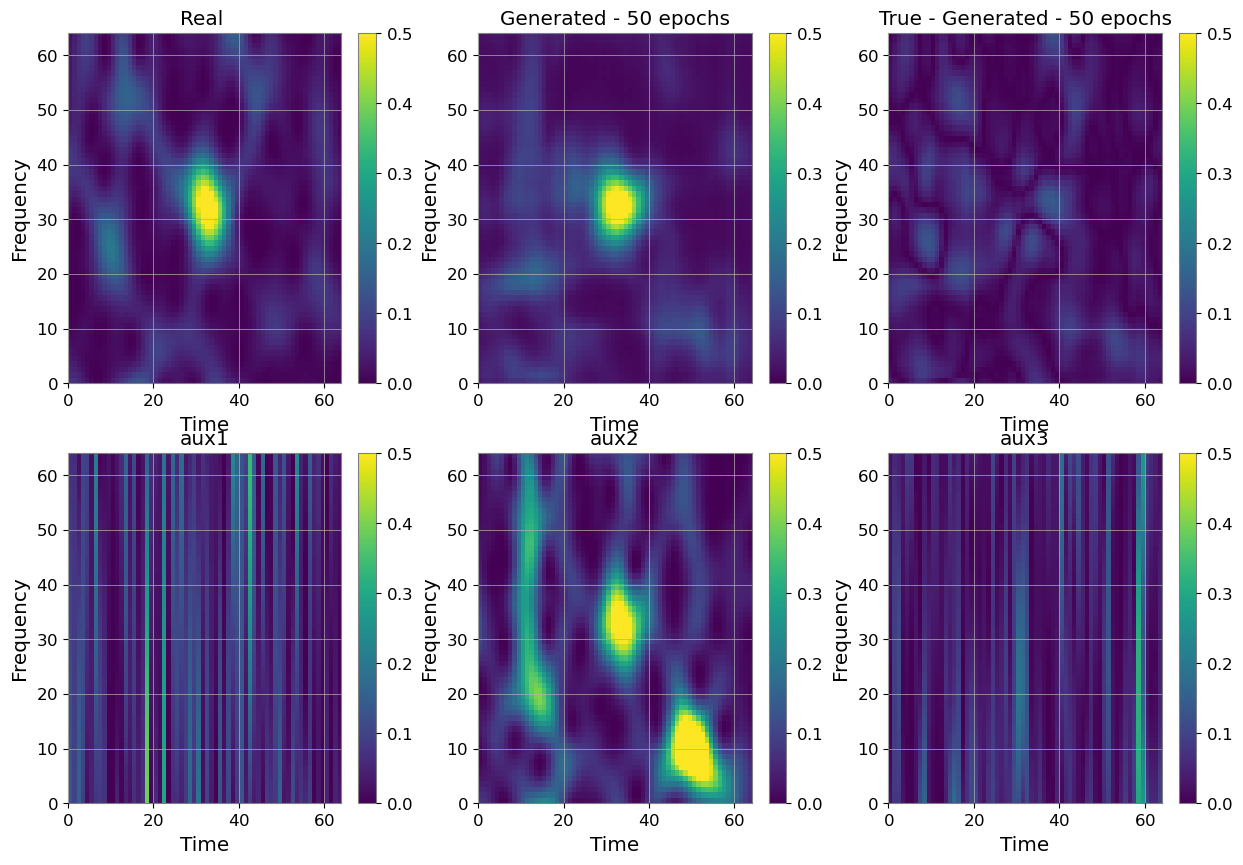

---------------------------
IMAGE 1


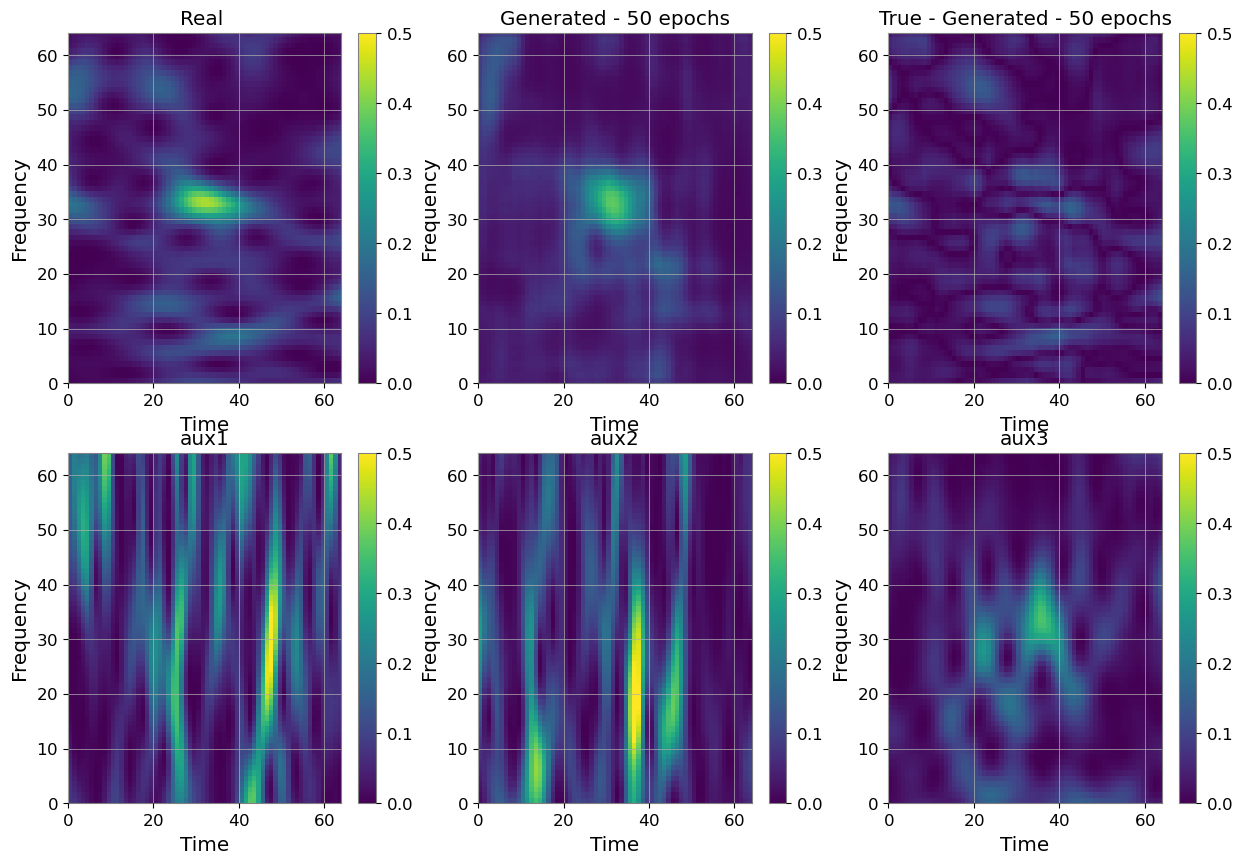

---------------------------
IMAGE 2


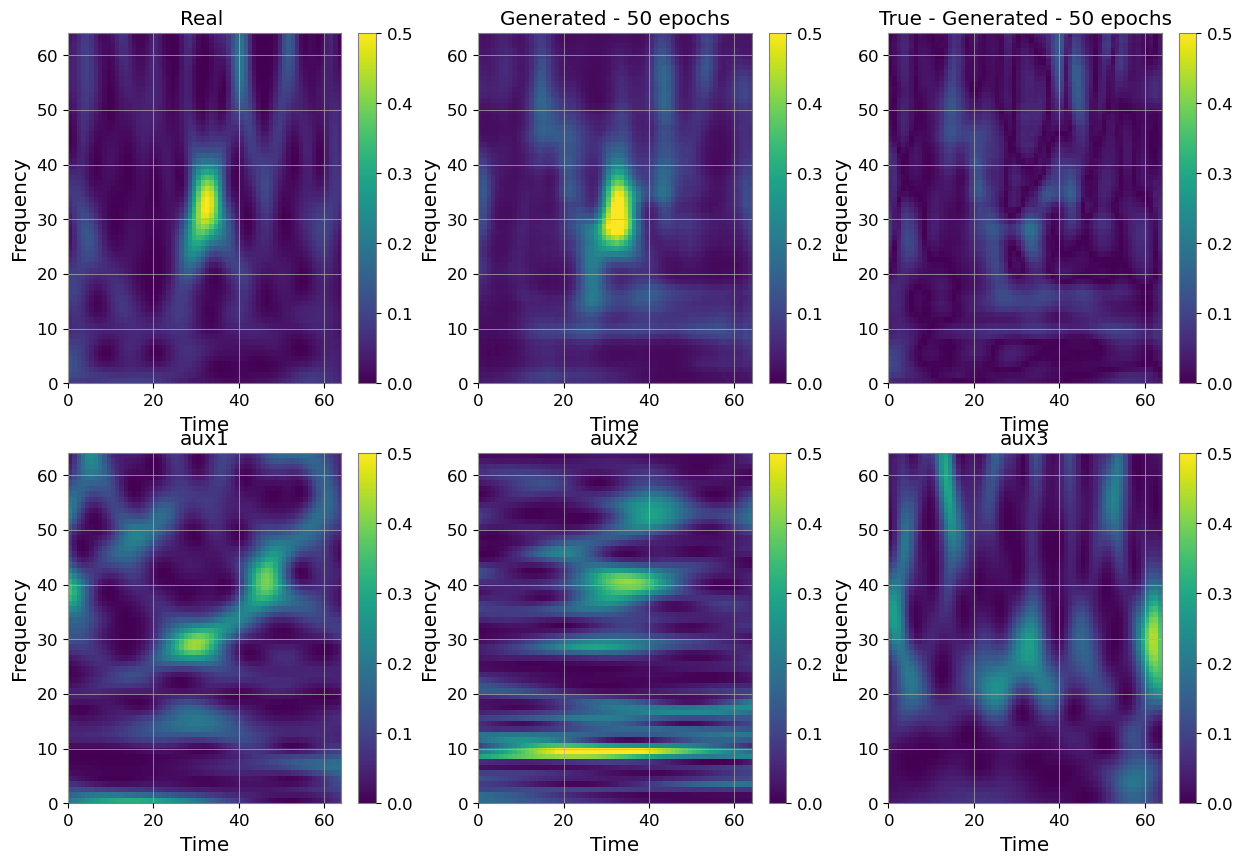

---------------------------
IMAGE 3


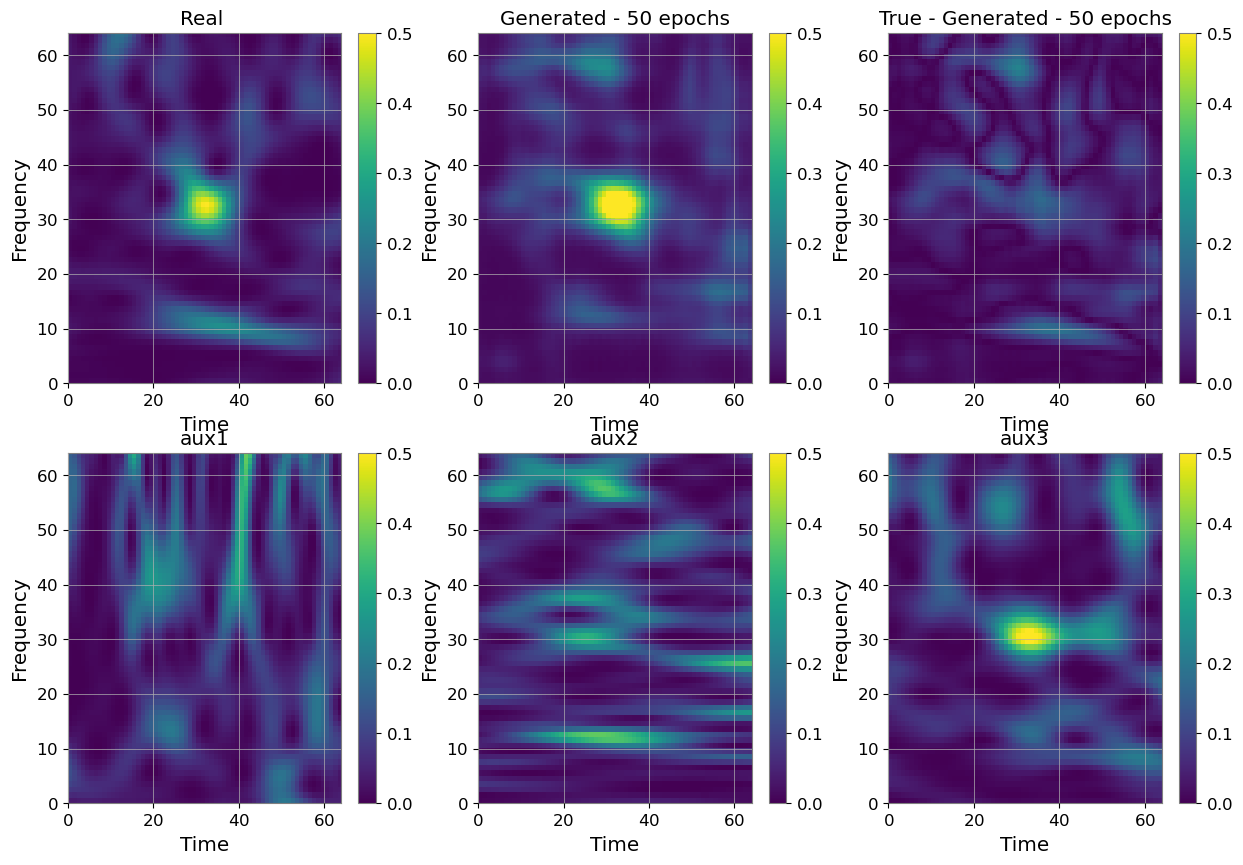

---------------------------
IMAGE 4


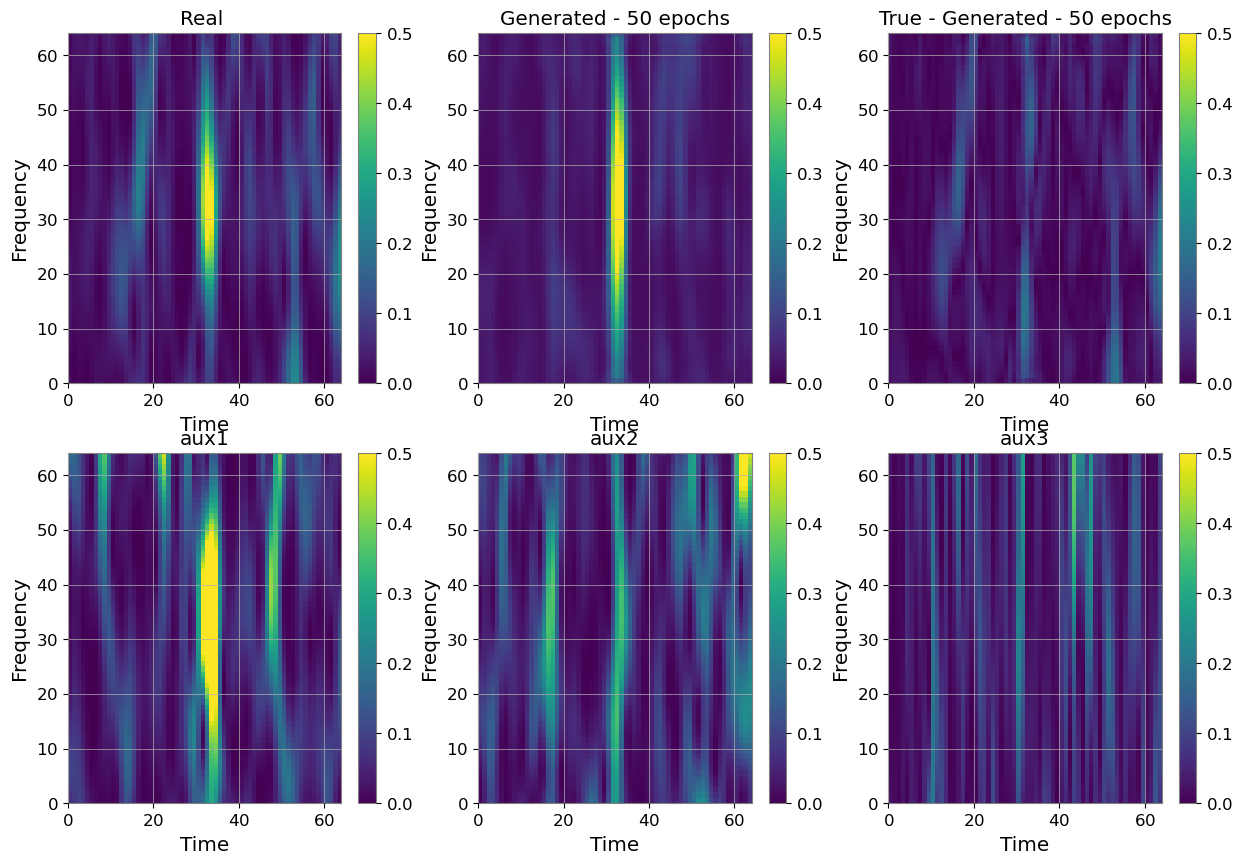

---------------------------
IMAGE 5


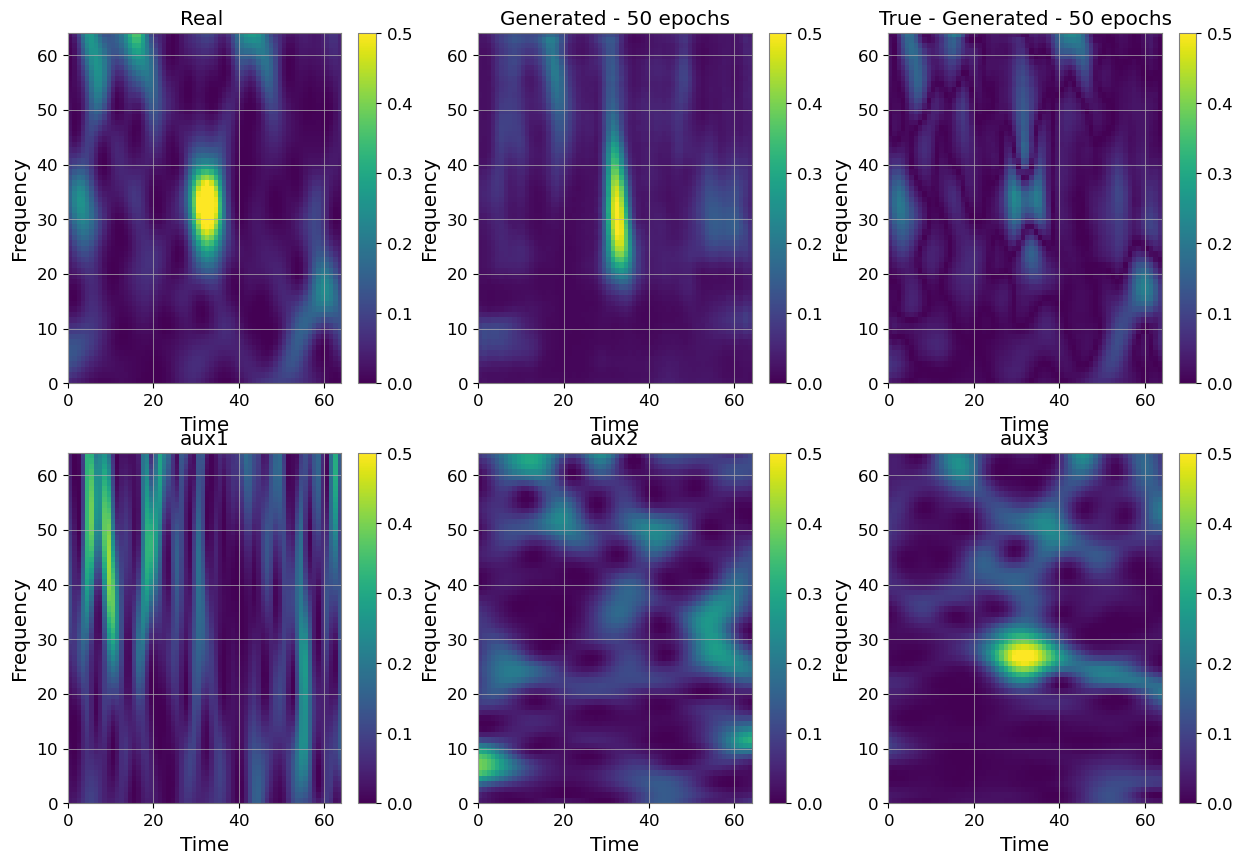

---------------------------
IMAGE 6


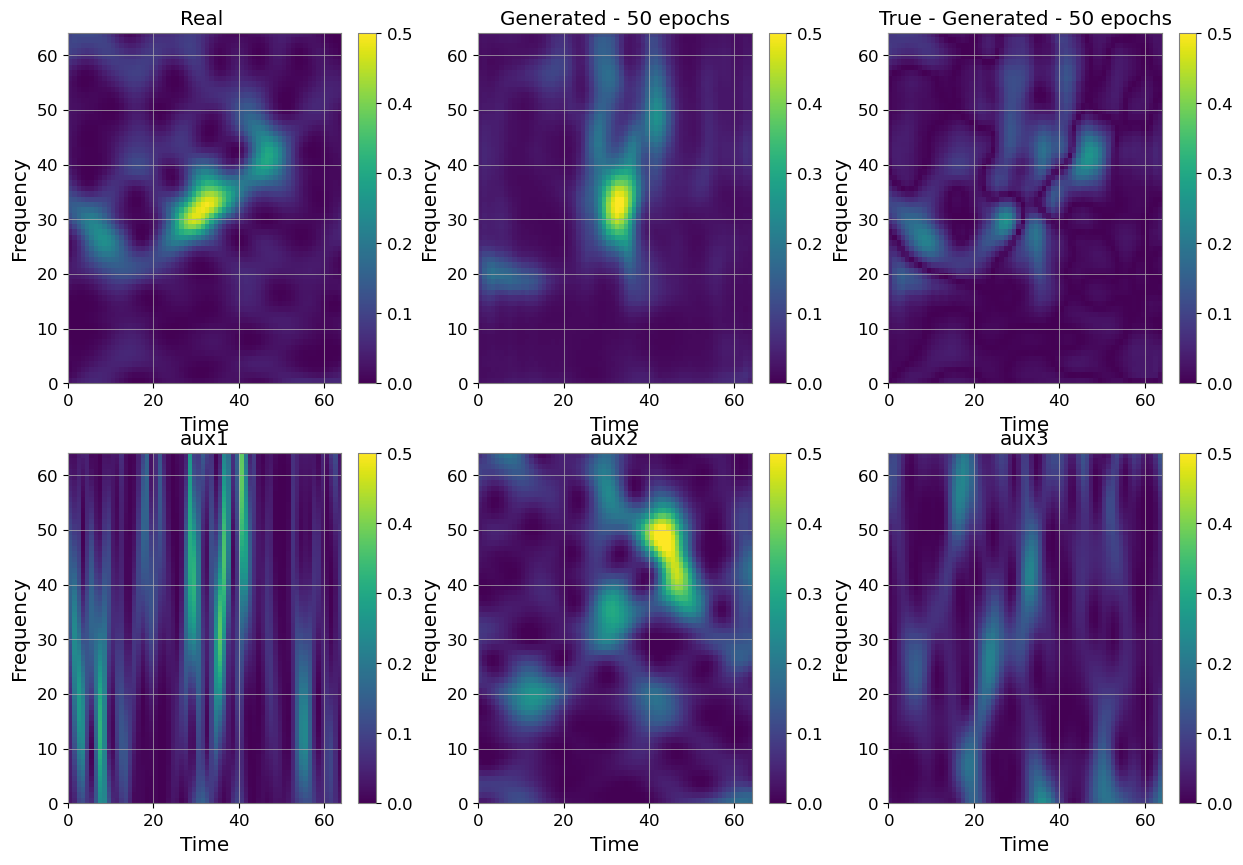

---------------------------
IMAGE 7


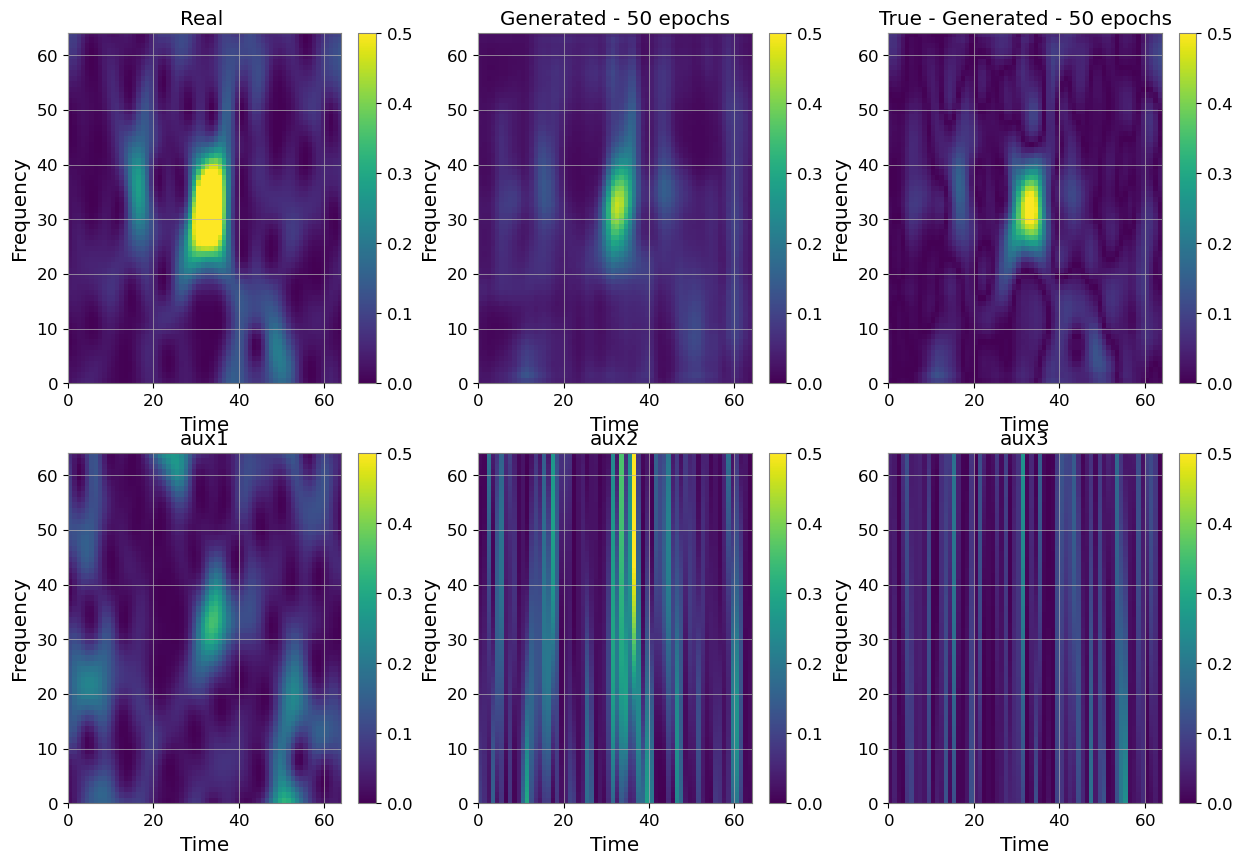

---------------------------
IMAGE 8


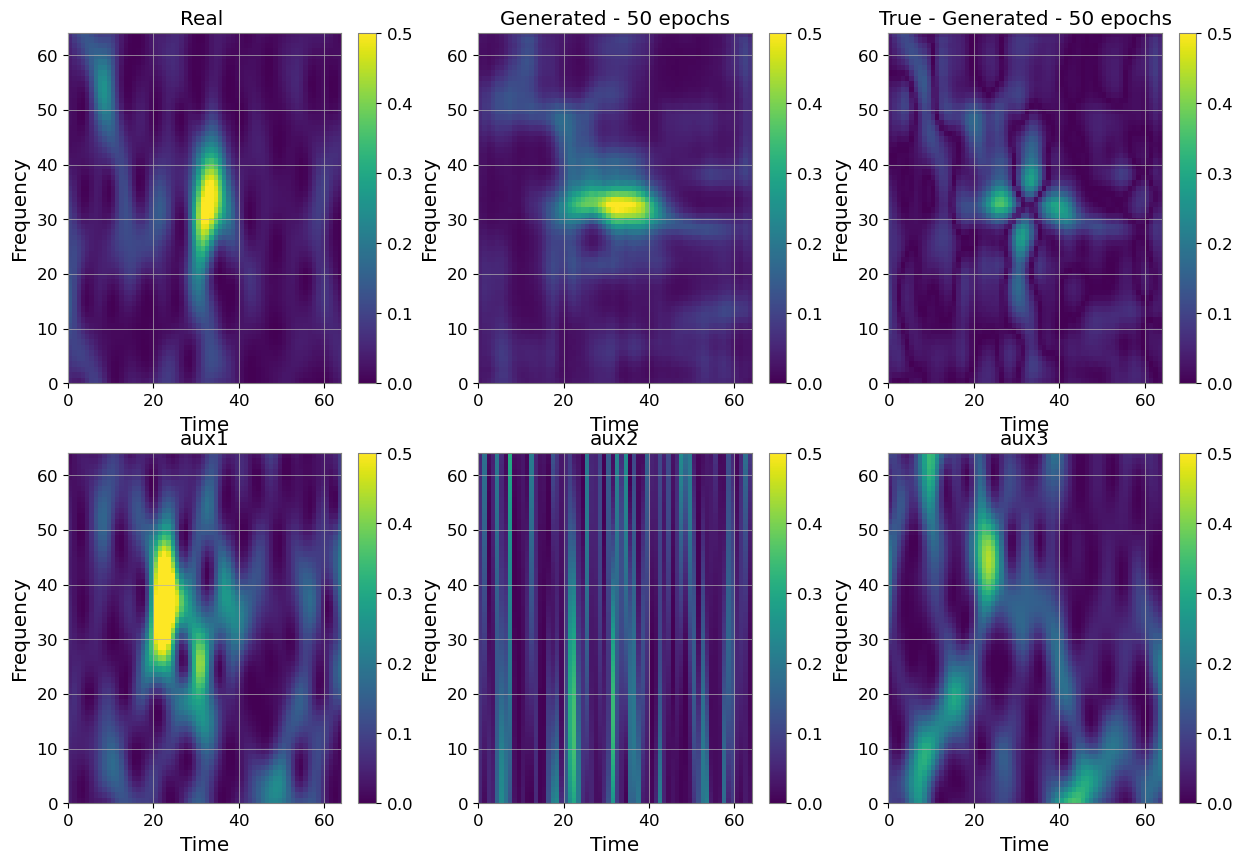

---------------------------
IMAGE 9


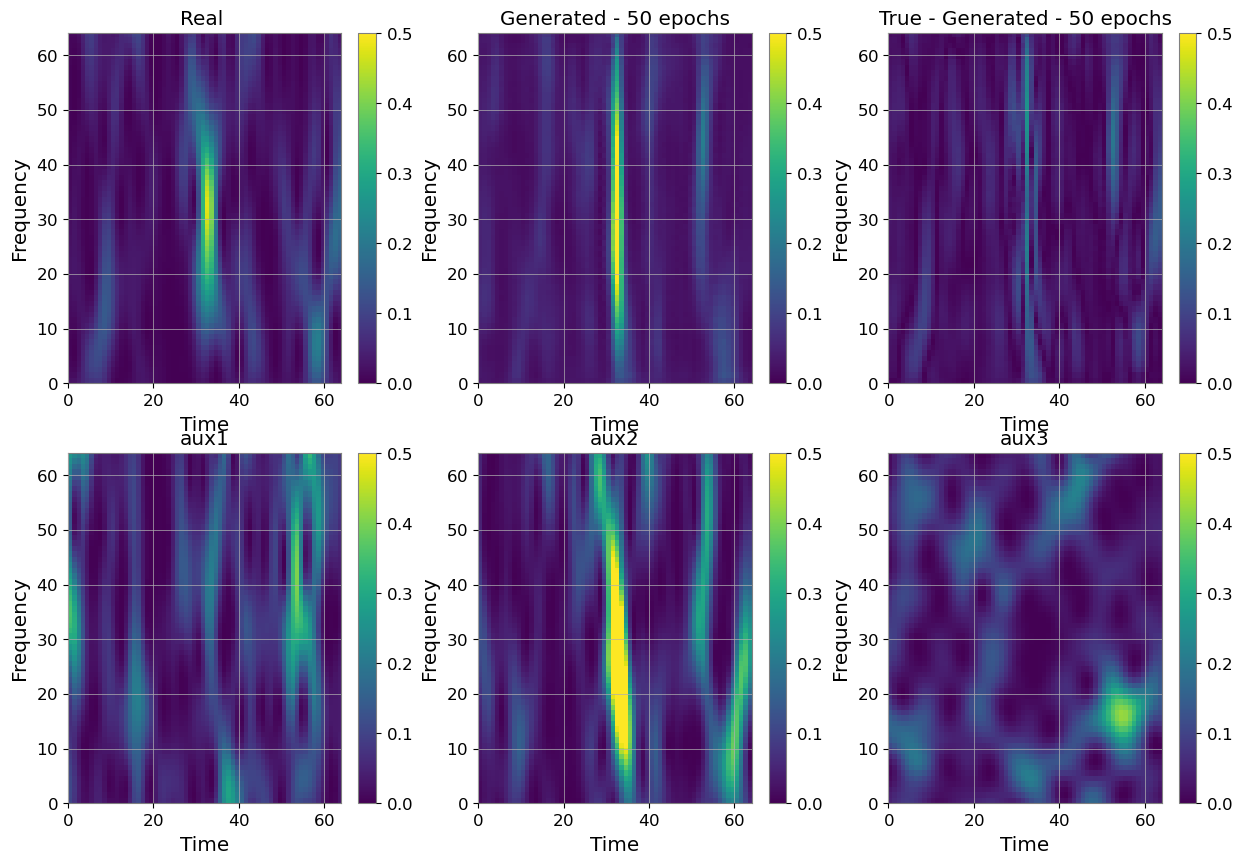

---------------------------
IMAGE 10


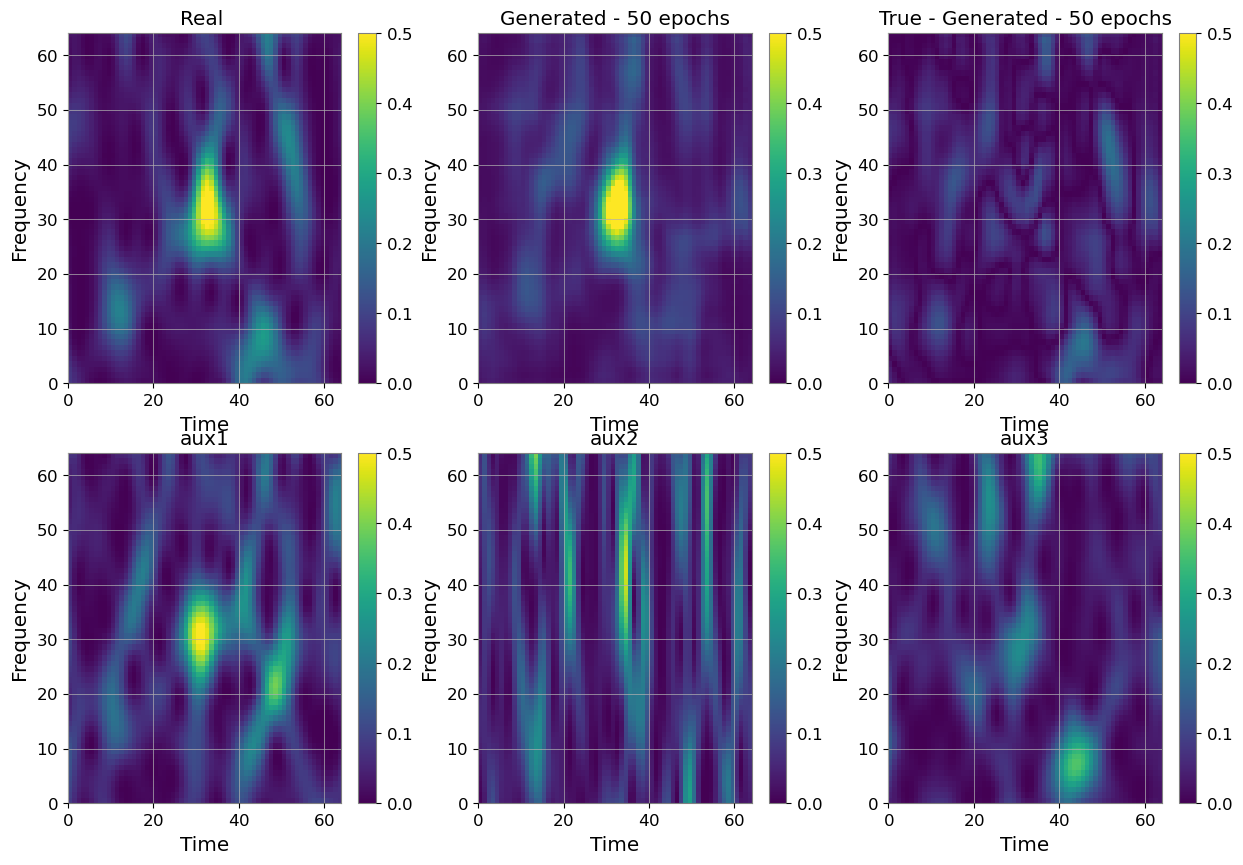

---------------------------
IMAGE 11


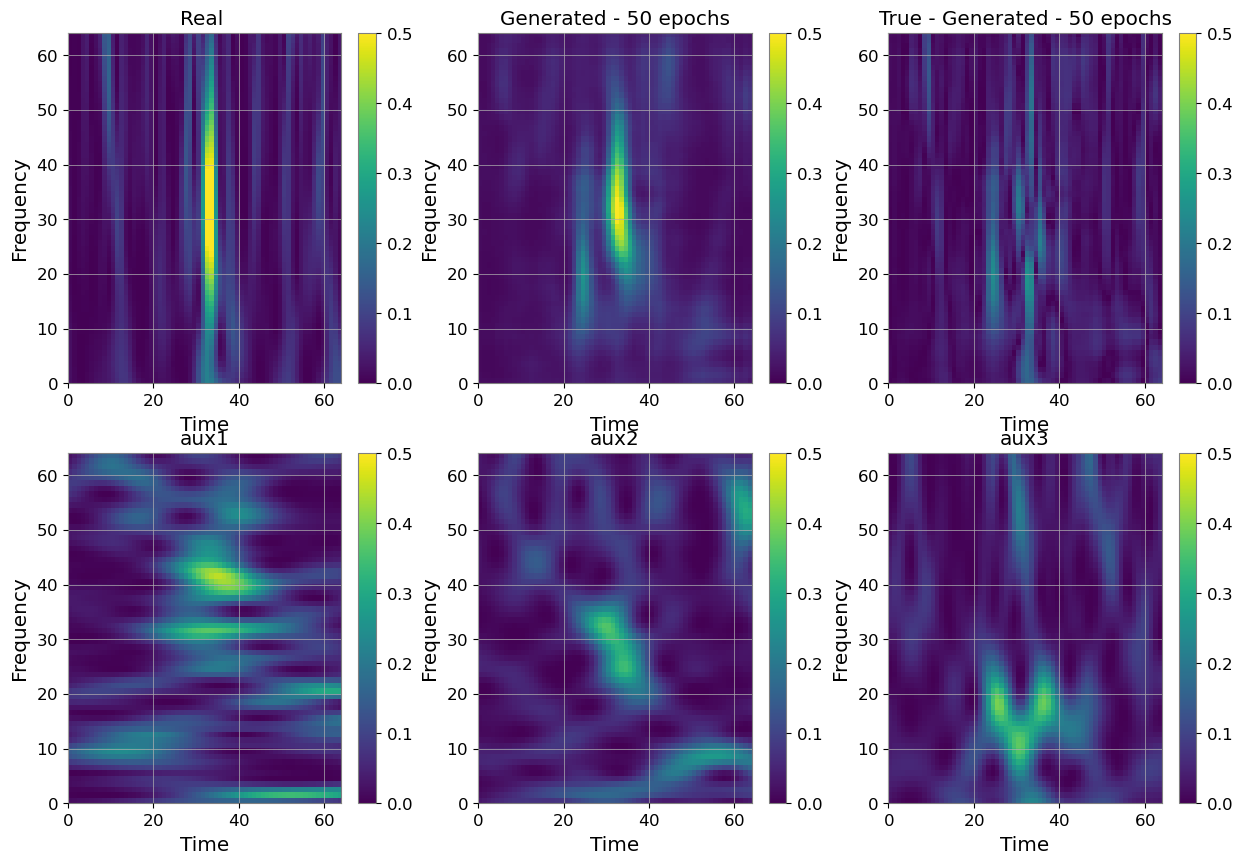

---------------------------
IMAGE 12


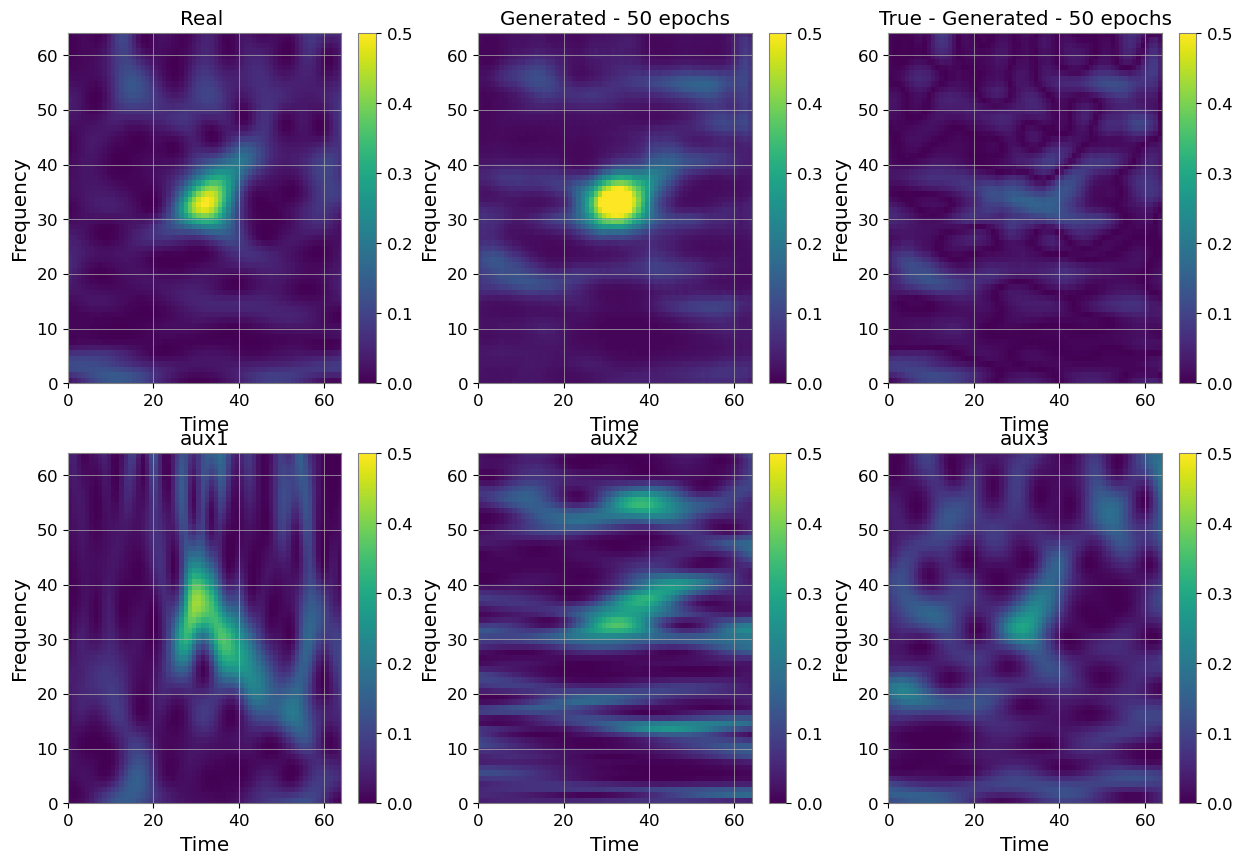

---------------------------
IMAGE 13


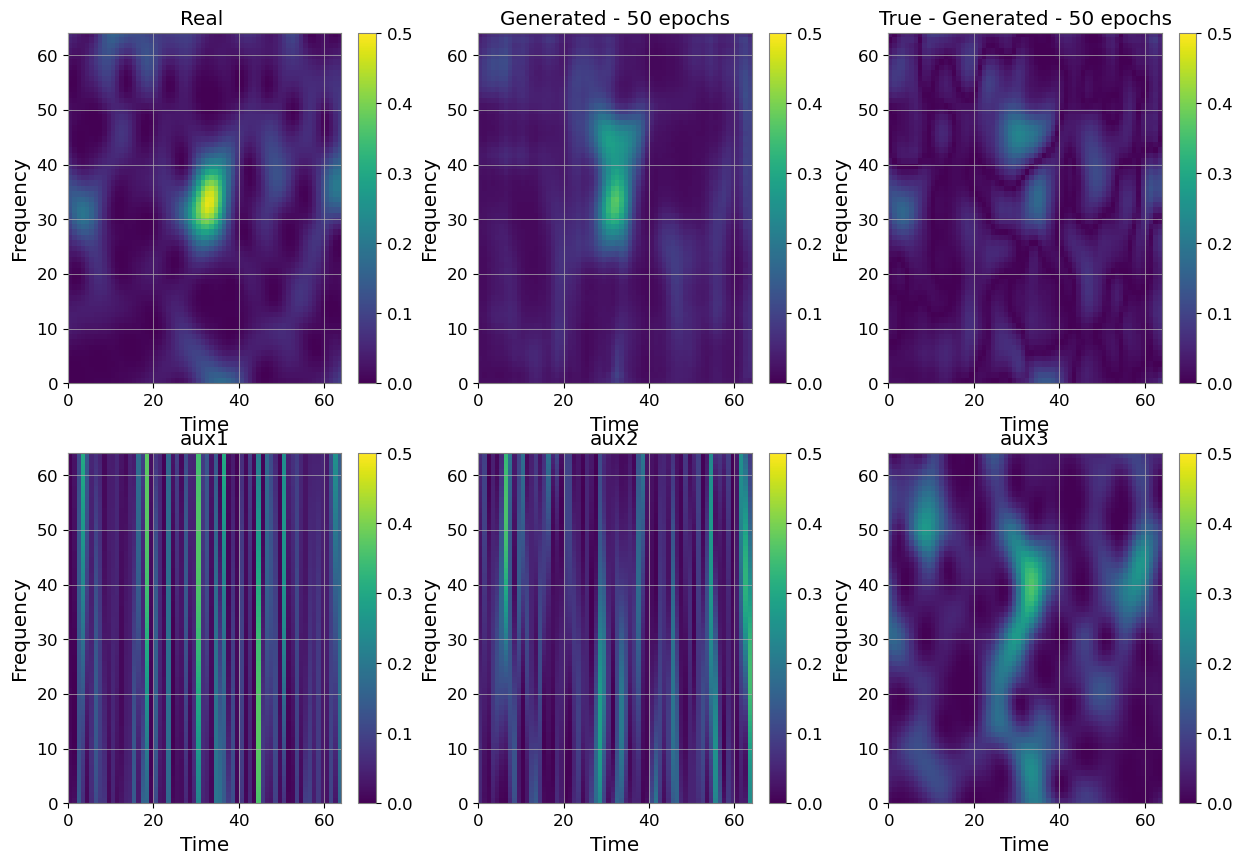

---------------------------
IMAGE 14


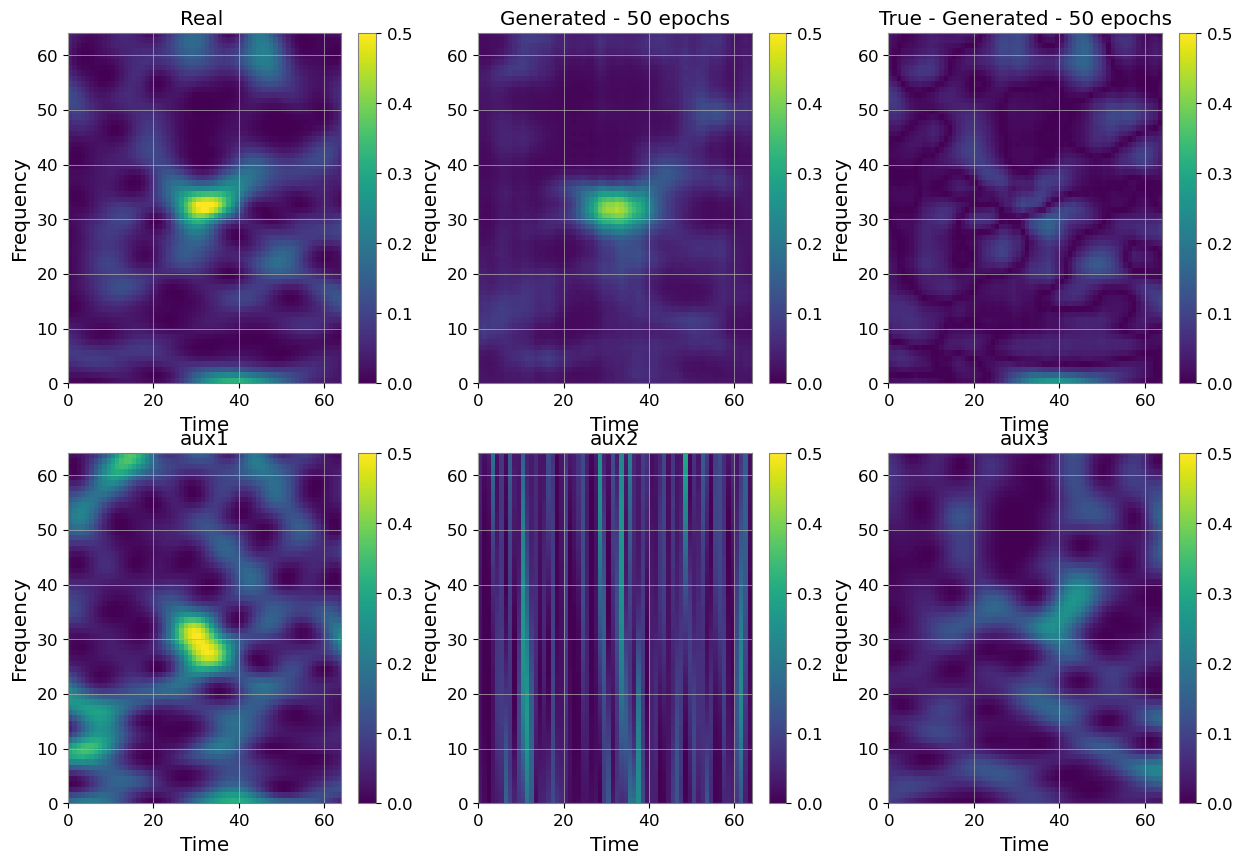

---------------------------
IMAGE 15


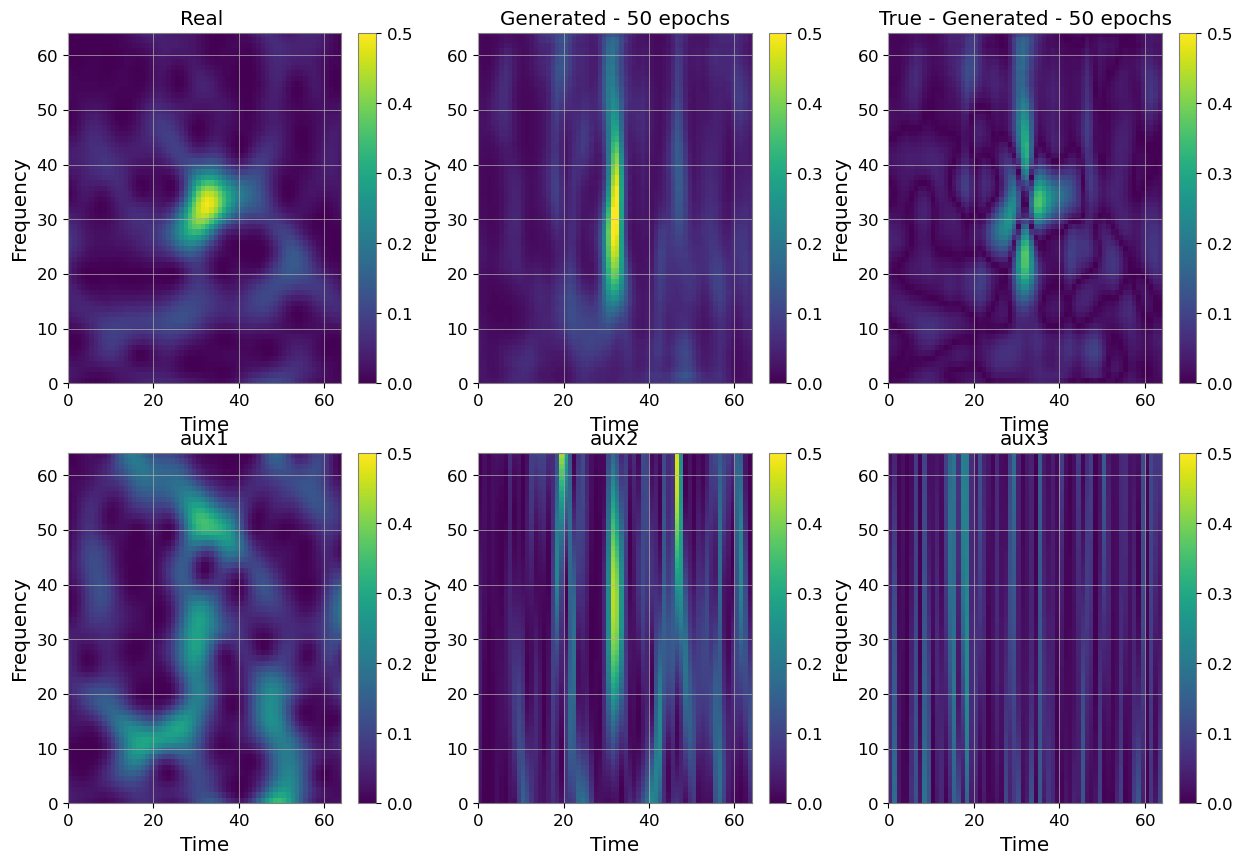

---------------------------
IMAGE 16


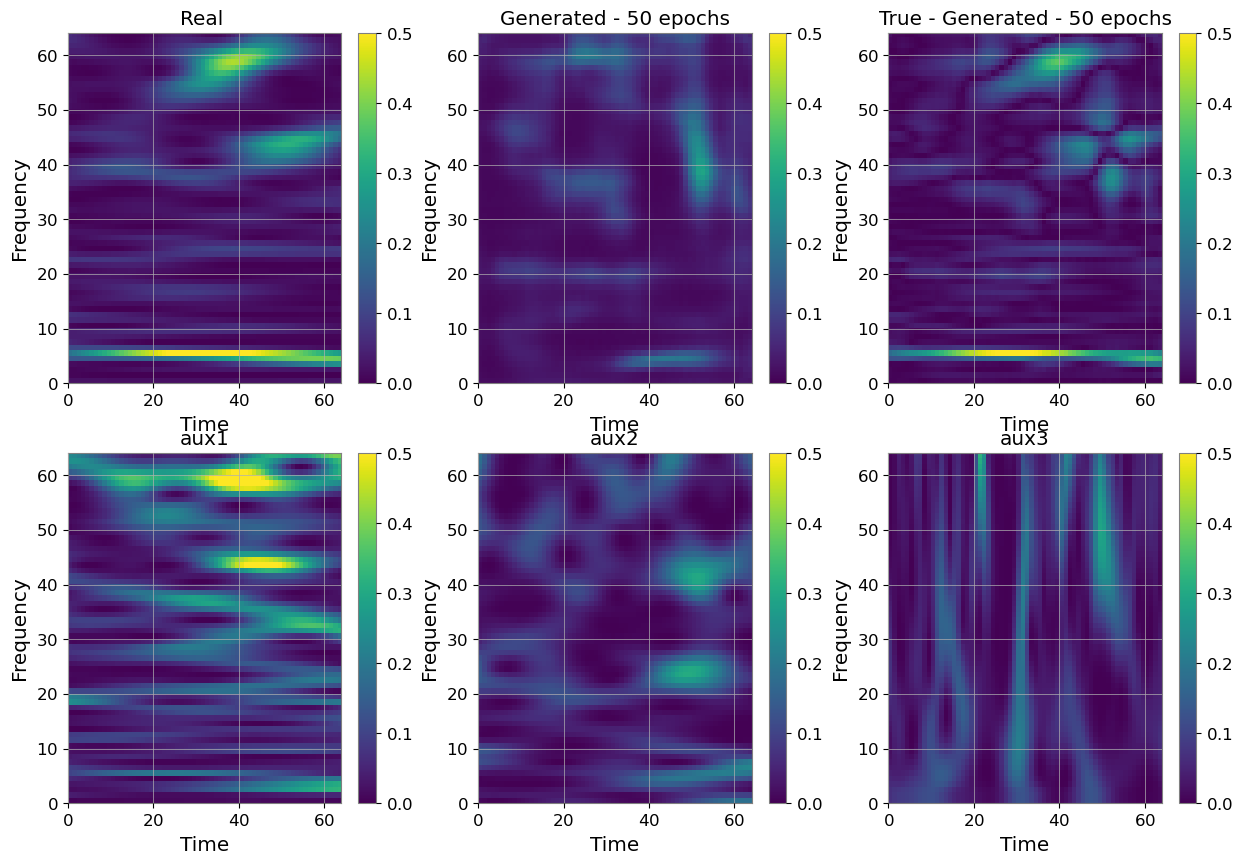

---------------------------
IMAGE 17


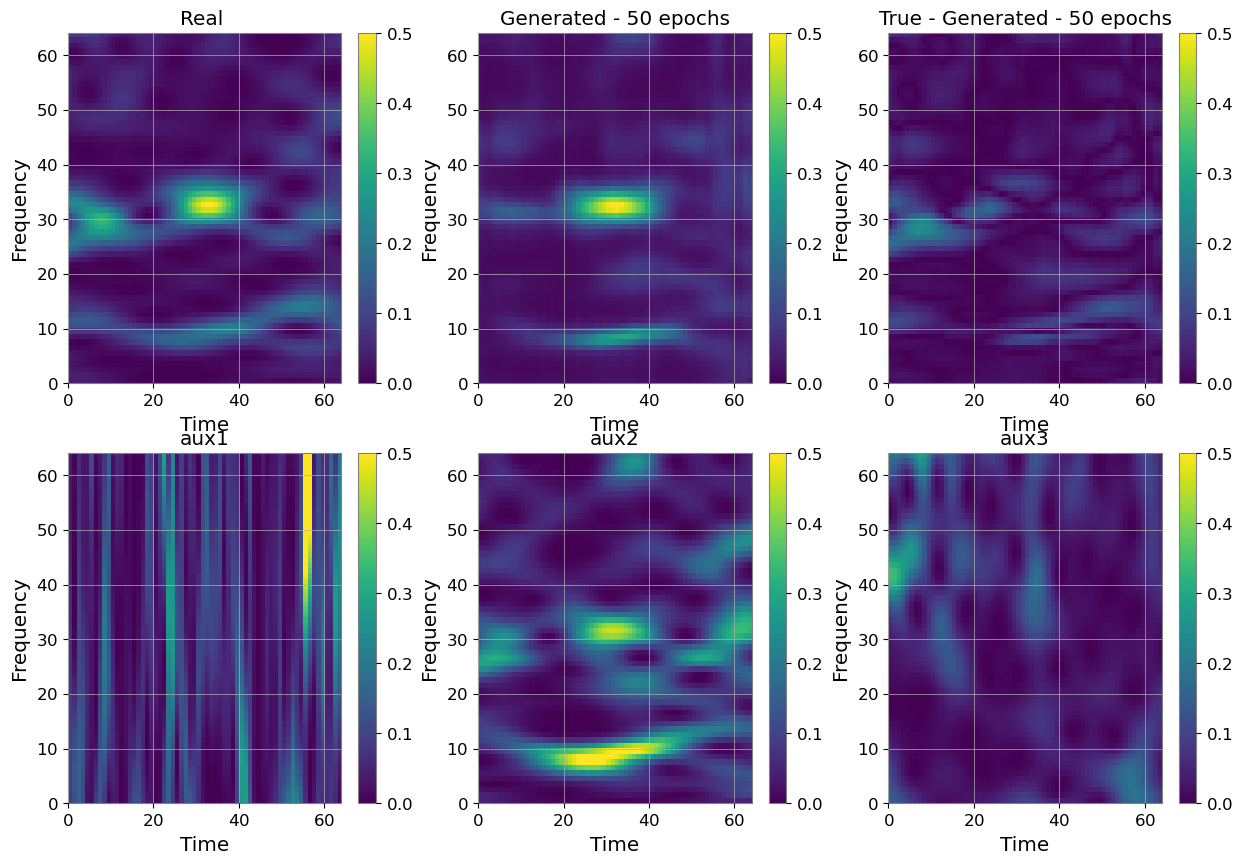

---------------------------
IMAGE 18


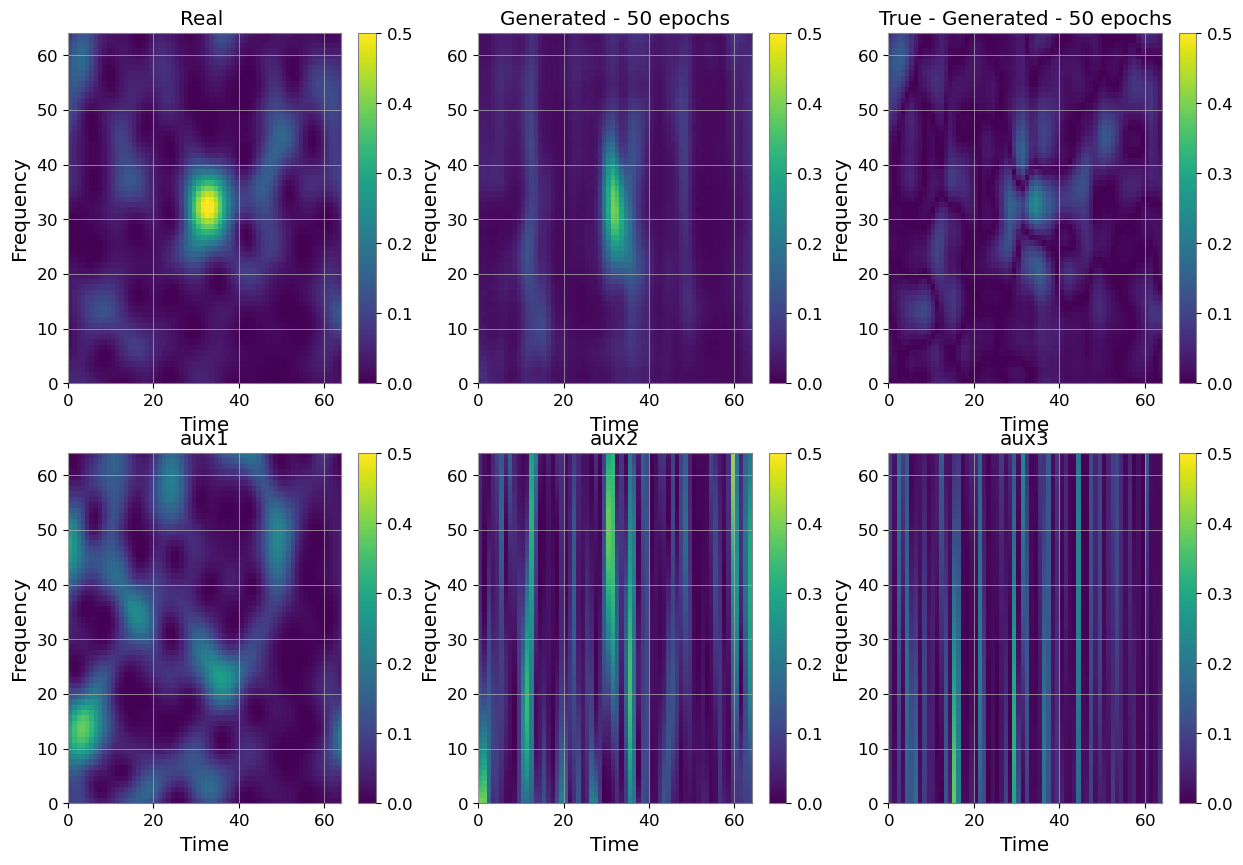

---------------------------
IMAGE 19


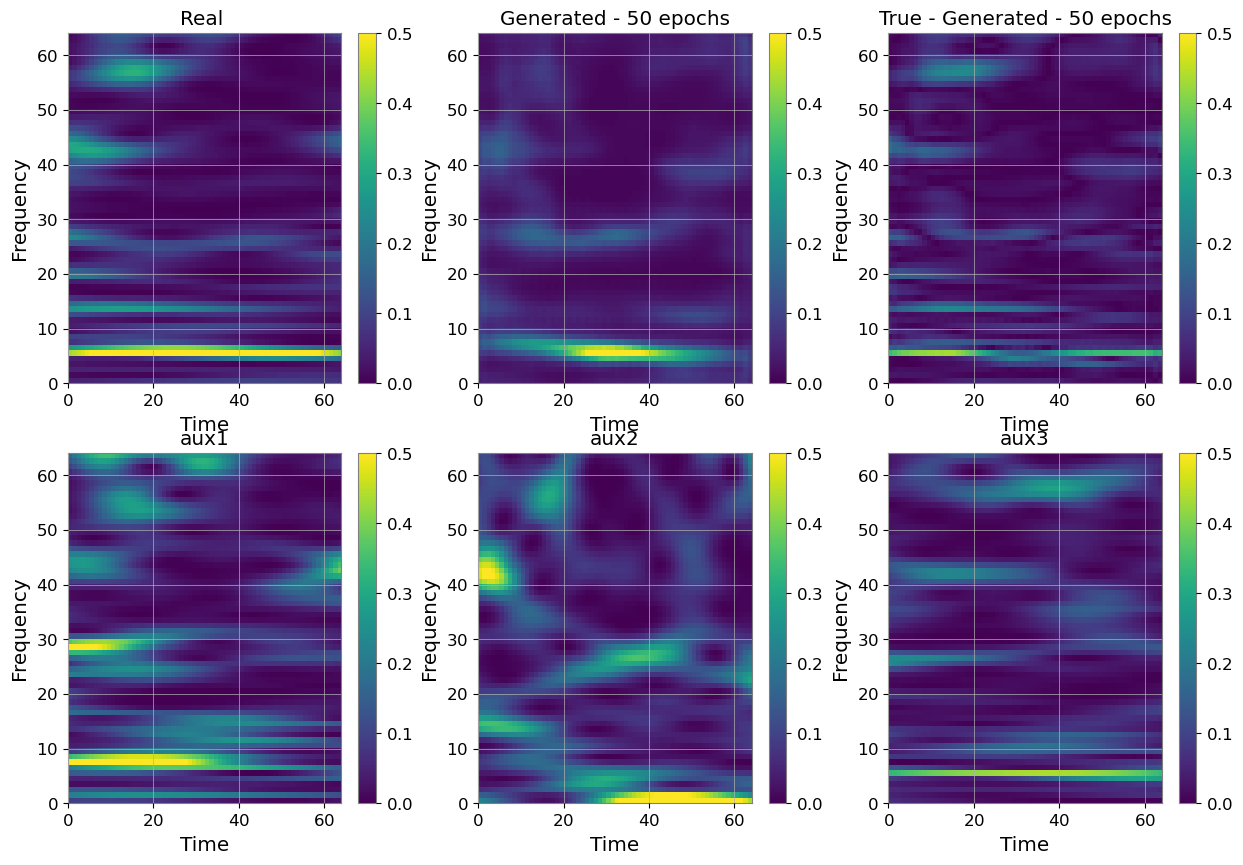

In [183]:
import matplotlib.pyplot as plt
v_max=0.5

for i in range(generated_post.shape[0]):
    print('---------------------------')
    print(f'IMAGE {i}')
    qplt_g = np.flipud(generated_post[i, 0].detach().cpu().numpy().T)
    qplt_r = np.flipud(batch[i, 0].detach().cpu().numpy().T)
    qplt_aux1 = np.flipud(batch[i, 1].detach().cpu().numpy().T)
    qplt_aux2 = np.flipud(batch[i, 2].detach().cpu().numpy().T)
    qplt_aux3 = np.flipud(batch[i, 3].detach().cpu().numpy().T)

    # Create a single subfigure with two plots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Plot for Real
    im_r = axes[0,0].imshow(qplt_r, aspect='auto', extent=[0, generated_post[i, 0].shape[0], 0, generated_post[i, 0].shape[1]],vmin=0, vmax=v_max)
    axes[0,0].set_title('Real ')
    axes[0,0].set_xlabel('Time')
    axes[0,0].set_ylabel('Frequency')
    fig.colorbar(im_r, ax=axes[0,0])  # Add colorbar for Real

    # Plot for Generated
    im_g = axes[0,1].imshow(qplt_g, aspect='auto', extent=[0, generated_post[i, 0].shape[0], 0, generated_post[i, 0].shape[1]], vmin=0, vmax=v_max)
    axes[0,1].set_title('Generated - 50 epochs')
    axes[0,1].set_xlabel('Time')
    axes[0,1].set_ylabel('Frequency')
    fig.colorbar(im_g, ax=axes[0,1])  # Add colorbar for Generated
    
    im_g = axes[0,2].imshow(abs(qplt_g-qplt_r), aspect='auto', extent=[0, generated_post[i, 0].shape[0], 0, generated_post[i, 0].shape[1]], vmin=0, vmax=v_max)
    axes[0,2].set_title('True - Generated - 50 epochs')
    axes[0,2].set_xlabel('Time')
    axes[0,2].set_ylabel('Frequency')
    fig.colorbar(im_g, ax=axes[0,2])  # Add colorbar for Generated
    
    # Plot for aux
    im_g = axes[1,0].imshow(qplt_aux1, aspect='auto', extent=[0, generated_post[i, 0].shape[0], 0, generated_post[i, 0].shape[1]], vmin=0, vmax=v_max)
    axes[1,0].set_title('aux1')
    axes[1,0].set_xlabel('Time')
    axes[1,0].set_ylabel('Frequency')
    fig.colorbar(im_g, ax=axes[1,0])  # Add colorbar for Generated
    # 
    im_g = axes[1,1].imshow(qplt_aux2, aspect='auto',extent=[0, generated_post[i, 0].shape[0], 0, generated_post[i, 0].shape[1]], vmin=0,vmax=v_max)
    axes[1,1].set_title('aux2')
    axes[1,1].set_xlabel('Time')
    axes[1,1].set_ylabel('Frequency')
    fig.colorbar(im_g, ax=axes[1,1])  # Add colorbar for Generated
    # 
    im_g = axes[1,2].imshow(qplt_aux3, aspect='auto', extent=[0, generated_post[i, 0].shape[0], 0, generated_post[i, 0].shape[1]], vmin=0, vmax=v_max)
    axes[1,2].set_title('aux3')
    axes[1,2].set_xlabel('Time')
    axes[1,2].set_ylabel('Frequency')
    fig.colorbar(im_g, ax=axes[1,2])  # Add colorbar for Generated

    
    # Show the subfigure
    plt.show()


In [ ]:
'''# Define the path to your checkpoint file
checkpoint_path = '/home/jovyan/checkpoints/checkpoint_epoch_best.pth'

# Load the checkpoint
checkpoint = torch.load(checkpoint_path)

# Load the model state from the checkpoint
generator.load_state_dict(checkpoint['model_state_dict'])'''

In [44]:
import torch
import torch.nn as nn

class Conv2dBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(Conv2dBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.activation(x)
        return x

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, pool_size=(2, 2), dropout=0.3):
        super(EncoderBlock, self).__init__()
        self.conv_block = Conv2dBlock(in_channels, out_channels)
        self.maxpool = nn.MaxPool2d(pool_size)
        self.dropout = nn.Dropout2d(dropout)

    def forward(self, x):
        features = self.conv_block(x)
        pooled = self.maxpool(features)
        pooled = self.dropout(pooled)
        return features, pooled

class Encoder(nn.Module):
    def __init__(self, input_channels):
        super(Encoder, self).__init__()
        self.block1 = EncoderBlock(input_channels, 64)
        self.block2 = EncoderBlock(64, 128)
        self.block3 = EncoderBlock(128, 256)
        self.block4 = EncoderBlock(256, 512)

    def forward(self, x):
        f1, p1 = self.block1(x)
        f2, p2 = self.block2(p1)
        f3, p3 = self.block3(p2)
        f4, p4 = self.block4(p3)
        return p4, (f1, f2, f3, f4)

class Bottleneck(nn.Module):
    def __init__(self):
        super(Bottleneck, self).__init__()
        self.conv_block = Conv2dBlock(512, 1024)

    def forward(self, x):
        return self.conv_block(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, dropout=0.3):
        super(DecoderBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, padding=1, output_padding=1)
        self.dropout = nn.Dropout2d(dropout)
        self.conv_block = Conv2dBlock(out_channels * 2, out_channels)

    def forward(self, x, conv_output):
        x = self.deconv(x, output_size=conv_output.size())
        x = torch.cat([x, conv_output], dim=1)
        x = self.dropout(x)
        x = self.conv_block(x)
        return x

class Decoder(nn.Module):
    def __init__(self, output_channels):
        super(Decoder, self).__init__()
        self.block6 = DecoderBlock(1024, 512)
        self.block7 = DecoderBlock(512, 256)
        self.block8 = DecoderBlock(256, 128)
        self.block9 = DecoderBlock(128, 64)
        self.final_conv = nn.Conv2d(64, output_channels, kernel_size=1)
        

    def forward(self, x, convs):
        f1, f2, f3, f4 = convs
        x = self.block6(x, f4)
        x = self.block7(x, f3)
        x = self.block8(x, f2)
        x = self.block9(x, f1)
        outputs = self.final_conv(x)
        
        return outputs

class UNet(nn.Module):
    def __init__(self, input_channels=3, output_channels=1):
        super(UNet, self).__init__()
        self.encoder = Encoder(input_channels)
        self.bottleneck = Bottleneck()
        self.decoder = Decoder(output_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        encoder_output, convs = self.encoder(x)
        bottleneck_output = self.bottleneck(encoder_output)
        outputs = self.decoder(bottleneck_output, convs)
        return self.sigmoid(outputs)


In [19]:
def init_weights(net, init_type='normal', scaling=0.02):
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv')) != -1:
            torch.nn.init.normal_(m.weight.data, 0.0, scaling)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            torch.nn.init.normal_(m.weight.data, 1.0, scaling)
            torch.nn.init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function 

In [20]:
# utils function to generate data using the decoder    
def generate_data(generator,batch,normalize=True):
    #batch= transform(batch)
    target = batch[:,0].unsqueeze(1).to(device)
    input = batch[:,1:].to(device)
    #print(input.float())
    with torch.no_grad():
        generated = generator(input.float())
        if normalize:
            generated=normalize_(generated,1)
    return generated

In [48]:
# Example usage
input_channels = 3  # adjust based on your input data
output_channels = 1  # adjust based on your output data

try:
    del generator_unet
    print('generator deleted')
except:
    pass


generator_unet = UNet(input_channels, output_channels).to(device)
init_weights(generator_unet, 'normal', scaling=.01)
print(generator_unet)

generator deleted
initialize network with normal
UNet(
  (encoder): Encoder(
    (block1): EncoderBlock(
      (conv_block): Conv2dBlock(
        (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (dropout): Dropout2d(p=0.3, inplace=False)
    )
    (block2): EncoderBlock(
      (conv_block): Conv2dBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (dropout): Dropout2d(p=0.3, inplace=False)
    )
    (block3): EncoderBlock(
      (conv_block): Conv2dBlock(
        (conv1): C

In [49]:
for batch in(tqdm(test_dataloader)):
    generated=generate_data(generator_unet,batch,normalize=False)
    break
generated[1,0].shape
#batch=transform(batch)

  0%|          | 0/59 [00:00<?, ?it/s]

torch.Size([64, 64])

---------------------------
IMAGE 0


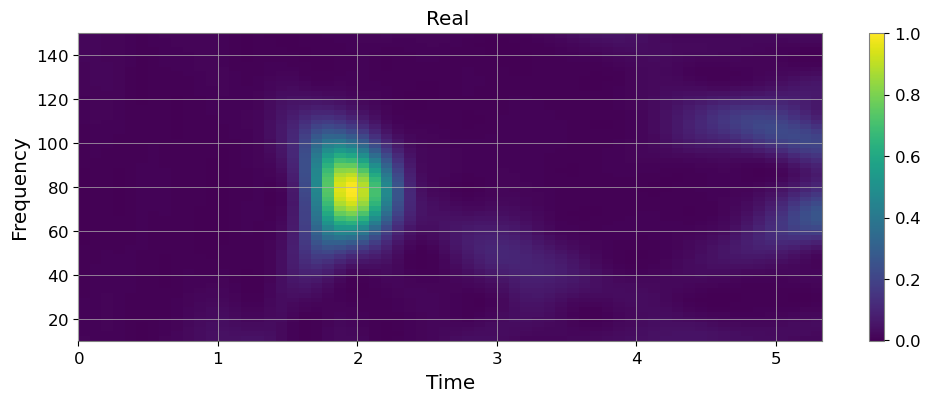

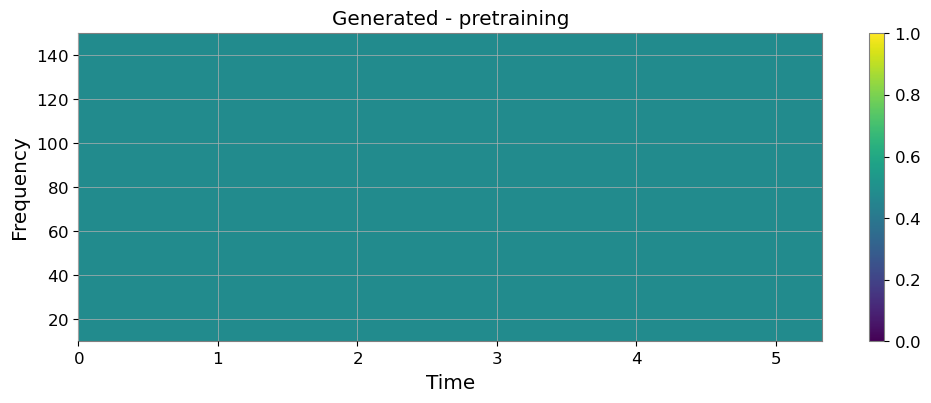

In [50]:
for i in range(1): #generated.shape[0]
    print('---------------------------')
    print(f'IMAGE {i}')
    qplt_g=generated[i,0].detach().cpu().numpy()
    qplt_r=batch[i,0].detach().cpu().numpy()
    
    plt.figure(figsize=(12, 4))
    plt.imshow(qplt_r, aspect='auto', extent=[0, 16/3, 10, 150])
    plt.title('Real ')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.colorbar()
    plt.show()
    
    plt.figure(figsize=(12, 4))
    plt.imshow(qplt_g, aspect='auto', extent=[0, 16/3, 10, 150],vmin=0,vmax=1)
    plt.title('Generated - pretraining')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.colorbar()
    plt.show()
    
    

In [24]:
# Metric function: IOU

def calculate_iou_2d(generated, target, threshold):
    """
    Calculate Intersection over Union (IoU) in the 2D plane at the specified intensity threshold.

    Parameters:
    - generated: List of time series representing the generated spectrograms
    - target: List of time series representing the target spectrograms
    - threshold: Intensity threshold for determining the binary masks

    Returns:
    - IoU: Intersection over Union
    """
    # Extract spectrogram values from time series
    # print(generated[0][0])
    # print(generated[0][0].shape)
    # print(type(generated[0][0]))
    
    
    spectrograms_gen = [TimeSeries(t[0], dt=1/4096.0).q_transform(frange=(10, 1000)).value for t in generated]
    spectrograms_real = [TimeSeries(t[0], dt=1/4096.0).q_transform(frange=(10, 1000)).value for t in target]

    # Create binary masks based on the intensity threshold
    mask1 = [spectrogram >= threshold for spectrogram in spectrograms_gen]
    mask2 = [spectrogram >= threshold for spectrogram in spectrograms_real]

    # Calculate the intersection and union of the binary masks
    intersection = [np.logical_and(m1, m2) for m1, m2 in zip(mask1, mask2)]
    union = [np.logical_or(m1, m2) for m1, m2 in zip(mask1, mask2)]

    # Calculate Intersection over Union (IoU)
    iou_list = np.array([np.sum(inter) / np.sum(uni) for inter, uni in zip(intersection, union)])

    iou = iou_list.mean()
    return iou


In [25]:
#more sophisticated loss function

def log_cosh_loss(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    def _log_cosh(x: torch.Tensor) -> torch.Tensor:
        return x + torch.nn.functional.softplus(-2. * x) - math.log(2.0)
    return torch.mean(_log_cosh(y_pred - y_true))

class LogCoshLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(
        self, y_pred: torch.Tensor, y_true: torch.Tensor
    ) -> torch.Tensor:
        return log_cosh_loss(y_pred, y_true)

In [41]:
# Initialize optimizers and loss function
learning_rate = 0.000001

optimizer_G = torch.optim.Adam(generator_unet.parameters(), lr=learning_rate)

# You can also use SGD with momentum
# optimizer = torch.optim.SGD(generator_unet.parameters(), lr=learning_rate, momentum=momentum)

save_checkpoint = '/home/jovyan/unet/generator_unet_weights.checkpoint_epoch_{}.pth'
num_epochs = 5

loss = nn.L1Loss()


In [42]:
def train_unet(n_epochs,generator,criterion,optimizer,dataloader,val_loader,accuracy,checkpoint_path, save_best=False):
    # num_epochs: (int) number of epochs for training
    # generator: (NN.Module) NN model to train
    # criterion: (torch.optim) optimiser to use in training
    # dataloader: (DataLoader) training data
    # val_loader: (Dataloader) validation data
    # accuracy: (function) metric to measure performance of the model (Note not to be confused with loss)
    # checkpoint_path: (str) full path (including filename in the form filename_{}.pkl so to insert num_epoch) to save checkpoints at
    # save_best: (bool) if you want to save best performing model
    
    
    #uncomment all lines relative to accuracy if you want to measure IOU between generated and real spectrograms.
    #Note that it significantly slows down the whole process
    
    loss_plot =[]
    val_loss_plot =[]
    acc_plot=[]
    val_acc_plot=[]
    best_val_loss=5000000
    for epoch in tqdm(range(1,num_epochs+1)):
        epoch_loss =[]
        epoch_acc=[]
        for i, batch in enumerate(dataloader):
            #batch= transform(batch)
            target = batch[:,0].unsqueeze(1).to(device)
            #print(f'TARGET ON DEVICE: {target.get_device()}')
            target=target.float()
            input = batch[:,1:].to(device)
            #print(f'INPUT ON DEVICE: {input.get_device()}')
            
            optimizer.zero_grad()
            generated = generator(input.float())
            #generated=normalize_(generated,1)
            loss=criterion(generated,target)
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.detach().cpu().numpy())
            #acc=accuracy(generated.detach().cpu().numpy(),target.detach().cpu().numpy(),20)
            #epoch_acc.append(acc)
        val_loss =[]
        val_acc=[]
        for batch in(val_loader):
            #batch= transform(batch)
            target = batch[:,0].unsqueeze(1).to(device)
            target=target.float()
            input = batch[:,1:].to(device)
            with torch.no_grad():
                generated = generator(input.float())
                #generated=normalize_(generated,1)
                loss=criterion(generated,target)
                val_loss.append(loss.detach().cpu().numpy())
                #acc=accuracy(generated.detach().cpu().numpy(),target.detach().cpu().numpy(),20)
                #val_acc.append(acc)
        loss_plot.append(np.mean(epoch_loss))
        val_loss_plot.append(np.mean(val_loss))
        acc_plot.append(np.mean(epoch_acc))
        val_acc_plot.append(np.mean(val_acc))
        #print('epoch: {} loss: {} val loss: {} accuracy: {} val accuracy: {}'.format(epoch,loss_plot[-1],val_loss_plot[-1],acc_plot[-1],val_acc_plot[-1]))
        print('epoch: {} loss: {} val loss: {}'.format(epoch,loss_plot[-1],val_loss_plot[-1]))
        
        
            
        if save_best and val_loss_plot[-1] < best_val_loss: # instead of val_loss and best_val loss we should use accuracy!!!
            #create checkpoint
            checkpoint = {
            'epoch': epoch,
            'model_state_dict': generator.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_plot[-1],
            'val_loss': val_loss_plot[-1],
            }

            #save checkpoint only if it is better than the previous ones
            checkpoint_filename = checkpoint_path.format(epoch)
            torch.save(checkpoint, checkpoint_filename)

            #update best model
            best_val_loss = val_loss_plot[-1]
            best_checkpoint_filename = checkpoint_path.format('best')
            torch.save(checkpoint, best_checkpoint_filename)
        
        
    return loss_plot, val_loss_plot,acc_plot, val_acc_plot #,acc_plot, val_acc_plot,

In [43]:
loss_plot, val_loss_plot,acc_plot, val_acc_plot=train_unet(num_epochs,generator_unet,loss,optimizer_G,dataloader,test_dataloader,calculate_iou_2d,save_checkpoint)

  0%|          | 0/5 [00:00<?, ?it/s]

epoch: 1 loss: 0.4272238612174988 val loss: 0.39335301518440247
epoch: 2 loss: 0.0925617665052414 val loss: 0.06817596405744553
epoch: 3 loss: 0.06746028363704681 val loss: 0.06755097210407257
epoch: 4 loss: 0.06714361906051636 val loss: 0.06740789860486984
epoch: 5 loss: 0.06706970930099487 val loss: 0.06737487763166428


In [ ]:
# Plotting the loss
import matplotlib.pyplot as plt
plt.plot(loss_plot,color='b',label='train')
plt.plot(val_loss_plot,color='r',label='validation')
plt.title('L1 loss vs epoch - 64x64 UNet')
plt.legend()
#plt.savefig('lc.pdf')
#plt.yscale('log')
plt.show()

In [33]:
for batch in(tqdm(test_dataloader)):
    generated_post=generate_data(generator_unet,batch,normalize=False)
    break
generated_post[0,0].shape

  0%|          | 0/59 [00:00<?, ?it/s]

torch.Size([64, 64])

---------------------------
IMAGE 0


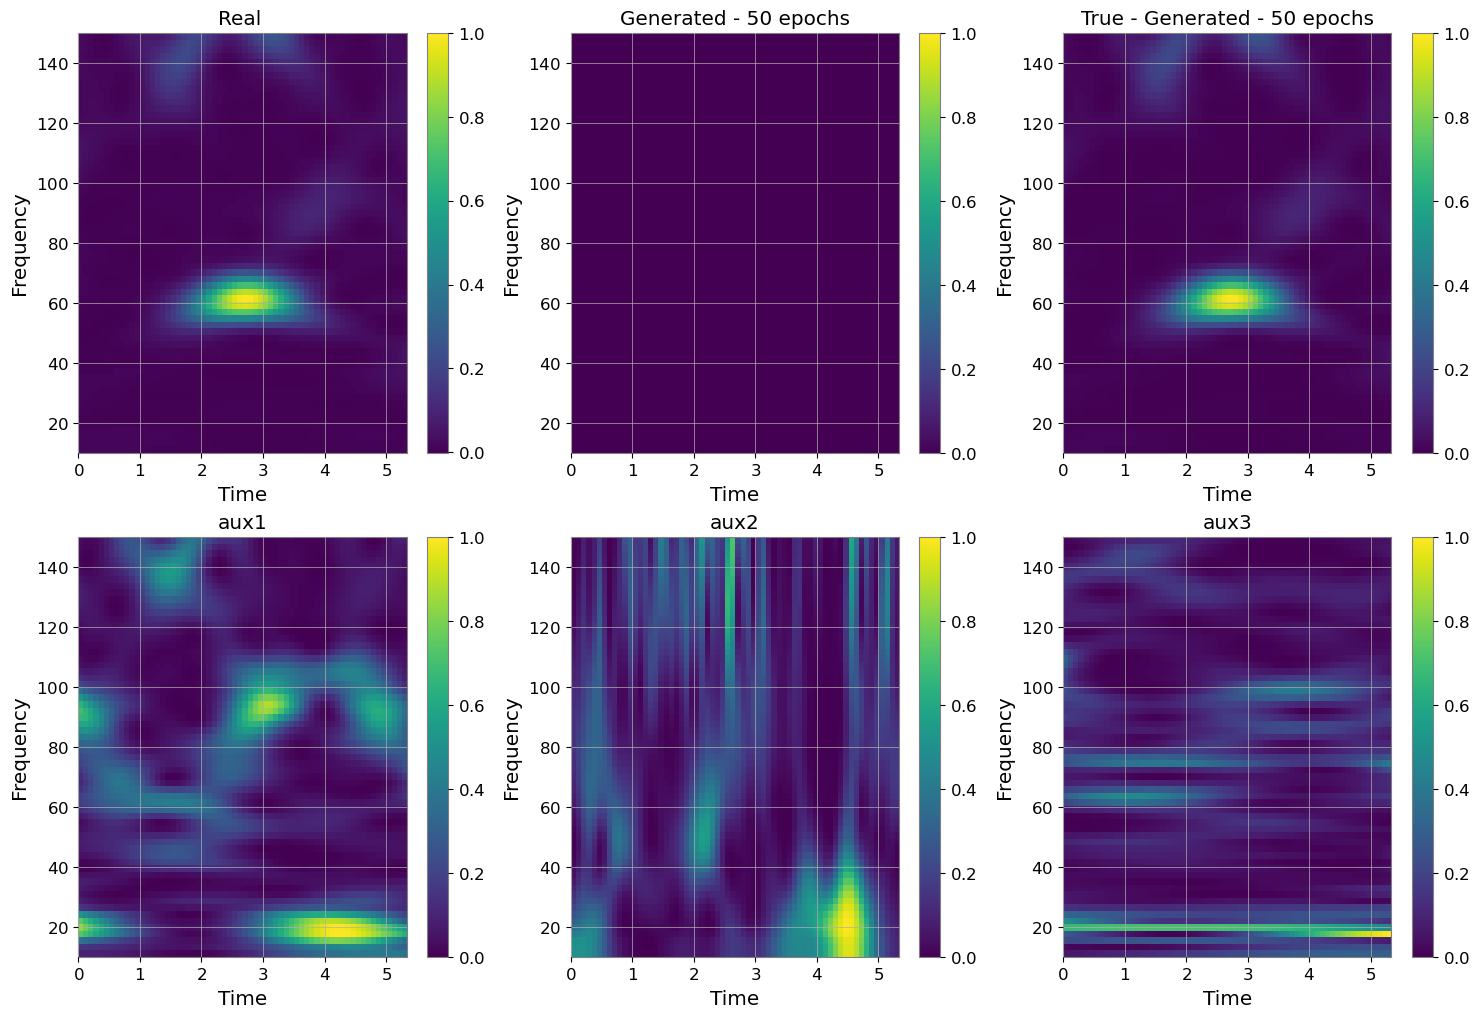

---------------------------
IMAGE 1


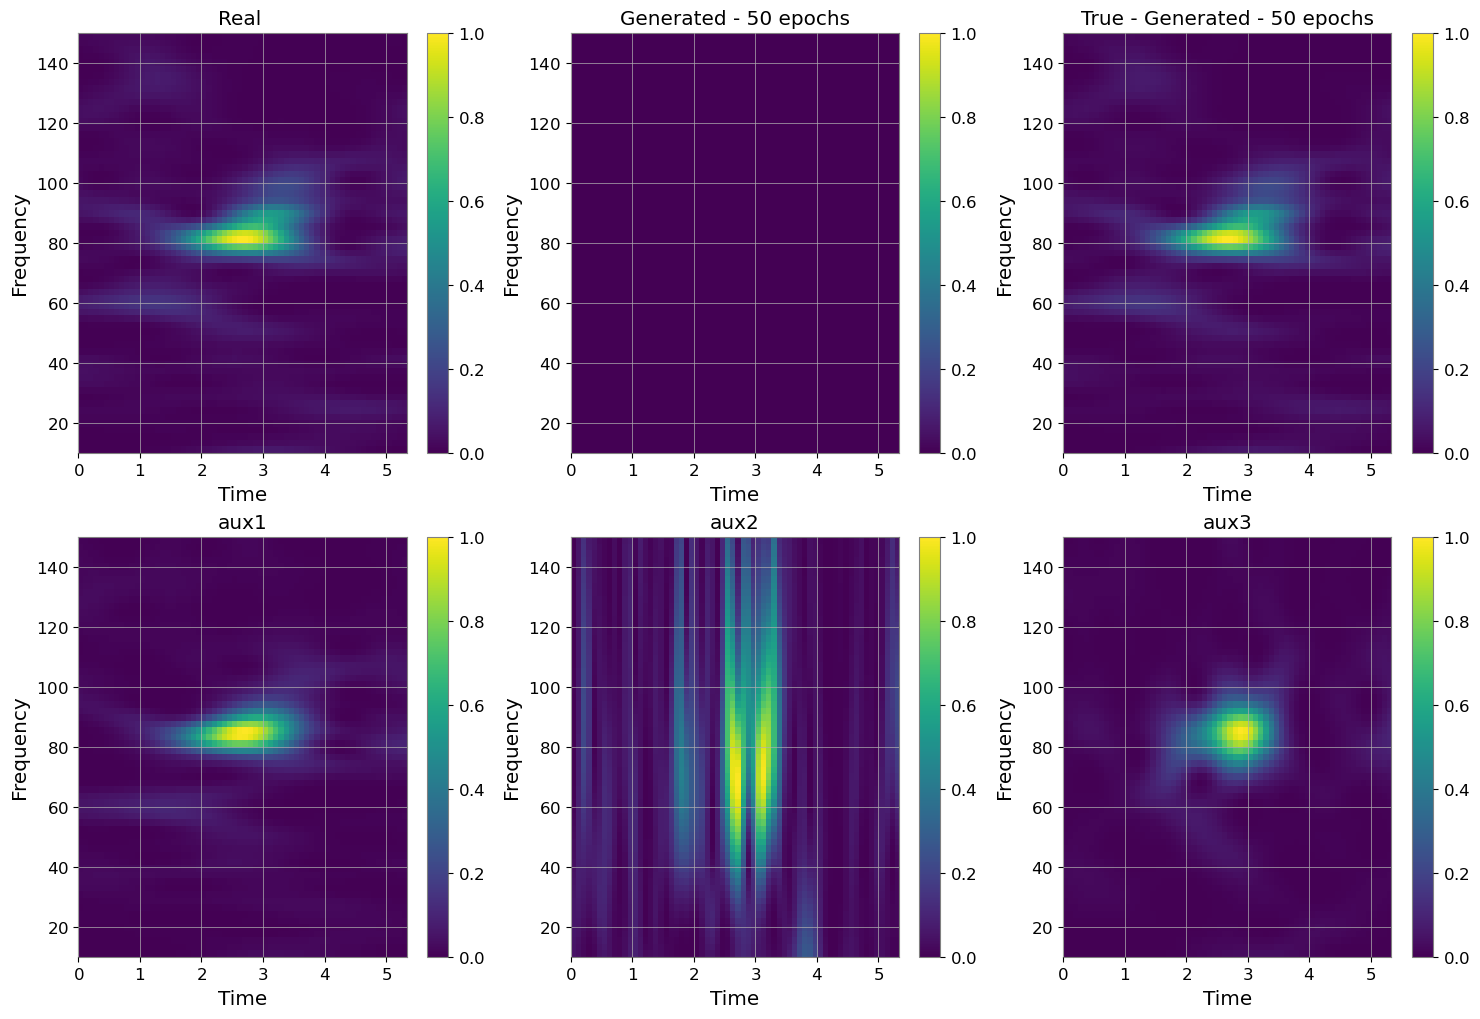

In [34]:
import matplotlib.pyplot as plt

# Assuming generated_post.shape[0] is the number of images
for i in range(2): #generated_post.shape[0]
    print('---------------------------')
    print(f'IMAGE {i}')
    qplt_g = np.flipud(generated_post[i, 0].detach().cpu().numpy().T)
    qplt_r = np.flipud(batch[i, 0].detach().cpu().numpy().T)
    qplt_aux1 = np.flipud(batch[i, 1].detach().cpu().numpy().T)
    qplt_aux2 = np.flipud(batch[i, 2].detach().cpu().numpy().T)
    qplt_aux3 = np.flipud(batch[i, 3].detach().cpu().numpy().T)

    # Create a single subfigure with two plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Plot for Real
    im_r = axes[0,0].imshow(qplt_r, aspect='auto', extent=[0, 16/3, 10, 150])
    axes[0,0].set_title('Real ')
    axes[0,0].set_xlabel('Time')
    axes[0,0].set_ylabel('Frequency')
    fig.colorbar(im_r, ax=axes[0,0])  # Add colorbar for Real

    # Plot for Generated
    im_g = axes[0,1].imshow(qplt_g, aspect='auto', extent=[0, 16/3, 10, 150], vmin=0, vmax=1)
    axes[0,1].set_title('Generated - 50 epochs')
    axes[0,1].set_xlabel('Time')
    axes[0,1].set_ylabel('Frequency')
    fig.colorbar(im_g, ax=axes[0,1])  # Add colorbar for Generated
    
    im_g = axes[0,2].imshow(abs(qplt_g-qplt_r), aspect='auto', extent=[0, 16/3, 10, 150], vmin=0, vmax=1)
    axes[0,2].set_title('True - Generated - 50 epochs')
    axes[0,2].set_xlabel('Time')
    axes[0,2].set_ylabel('Frequency')
    fig.colorbar(im_g, ax=axes[0,2])  # Add colorbar for Generated
    
    # Plot for aux
    im_g = axes[1,0].imshow(qplt_aux1, aspect='auto', extent=[0, 16/3, 10, 150], vmin=0, vmax=1)
    axes[1,0].set_title('aux1')
    axes[1,0].set_xlabel('Time')
    axes[1,0].set_ylabel('Frequency')
    fig.colorbar(im_g, ax=axes[1,0])  # Add colorbar for Generated
    # 
    im_g = axes[1,1].imshow(qplt_aux2, aspect='auto', extent=[0, 16/3, 10, 150], vmin=0, vmax=1)
    axes[1,1].set_title('aux2')
    axes[1,1].set_xlabel('Time')
    axes[1,1].set_ylabel('Frequency')
    fig.colorbar(im_g, ax=axes[1,1])  # Add colorbar for Generated
    # 
    im_g = axes[1,2].imshow(qplt_aux3, aspect='auto', extent=[0, 16/3, 10, 150], vmin=0, vmax=1)
    axes[1,2].set_title('aux3')
    axes[1,2].set_xlabel('Time')
    axes[1,2].set_ylabel('Frequency')
    fig.colorbar(im_g, ax=axes[1,2])  # Add colorbar for Generated

    
    # Show the subfigure
    if i==2:
        break
    plt.show()


In [42]:
import torch
import torch.nn as nn

# U-Net generator
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Generator, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),          
        )

        # Decoder
        self.decoder = nn.Sequential(
            
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, out_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),  
            
            #nn.Tanh(),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# PatchGAN discriminator
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.3, inplace=True),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.3, inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.3, inplace=True),
            nn.Conv2d(64, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

# Example usage
input_channels = 3  # adjust based on your input data
output_channels = 1  # adjust based on your output data

try:
    del generator
    print('generator deleted')
except:
    pass

try:
    del discriminator
    print('discriminator deleted')
except:
    pass

generator = Generator(input_channels, output_channels).to(device)
discriminator = Discriminator(input_channels + output_channels).to(device)




generator deleted
discriminator deleted


In [52]:
# Initialize optimizers and loss function
learning_rate=0.0002
epochs=100
optimizer_G = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

criterion_GAN = nn.BCELoss()
criterion_L1 = nn.L1Loss()

In [44]:
def train_pix2pix(num_epochs, generator, discriminator, dataloader, val_loader,
                  criterion_GAN, criterion_L1, optimizer_G, optimizer_D,
                  checkpoint_path="/home/jovyan/checkpoints/pix2pix/pix2pix_checkpoint_epoch_{}.pth"):
    # num_epochs: (int) number of epochs for training
    # generator: (NN.Module) generator model to train
    # discriminator: (NN.Module) discriminator model to train
    # dataloader: (DataLoader) training data
    # val_loader: (DataLoader) validation data
    # criterion_GAN: GAN loss criterion
    # criterion_L1: L1 loss criterion
    # optimizer_G: generator optimizer
    # optimizer_D: discriminator optimizer
    # checkpoint_path: (str) full path to save checkpoints

    # Lists to store losses during training
    gen_loss_train, disc_loss_train, total_loss_train = [], [], []
    gen_loss_val, disc_loss_val, total_loss_val = [], [], []

    best_val_loss = float('inf')

    for epoch in tqdm(range(1, num_epochs + 1)):
        generator.train()
        discriminator.train()

        epoch_gen_loss, epoch_disc_loss, epoch_total_loss = [], [], []

        for i, batch in enumerate(dataloader):
            target_images = batch[:, 0:1].to(device)  # Adjust slicing based on your actual data structure
            target_images = target_images.float()
            input = batch[:, 1:].to(device)

            # Train Discriminator
            optimizer_D.zero_grad()

            fake_images = generator(input)
            fake_ab = torch.cat((input, fake_images), 1)
            real_ab = torch.cat((input, target_images), 1)

            real_labels = torch.ones((input.size(0), 1, 31, 31)).to(device)
            fake_labels = torch.zeros((input.size(0), 1, 31, 31)).to(device)

            pred_real = discriminator(real_ab)
            pred_fake = discriminator(fake_ab.detach())

            loss_D_real = criterion_GAN(pred_real, real_labels)
            loss_D_fake = criterion_GAN(pred_fake, fake_labels)

            loss_D = (loss_D_real + loss_D_fake) * 0.5
            loss_D.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()

            pred_fake = discriminator(fake_ab)
            loss_GAN = criterion_GAN(pred_fake, real_labels)
            loss_L1 = criterion_L1(fake_images, target_images)

            loss_G = loss_GAN + 100 * loss_L1  # Adjust the weight of L1 loss as needed
            loss_G.backward()
            optimizer_G.step()

            epoch_gen_loss.append(loss_GAN.item())
            epoch_disc_loss.append(loss_D.item())
            epoch_total_loss.append(loss_G.item())

        gen_loss_train.append(sum(epoch_gen_loss) / len(epoch_gen_loss))
        disc_loss_train.append(sum(epoch_disc_loss) / len(epoch_disc_loss))
        total_loss_train.append(sum(epoch_total_loss) / len(epoch_total_loss))

        # Validation
        generator.eval()
        discriminator.eval()

        val_gen_loss, val_disc_loss, val_total_loss = [], [], []

        for batch in val_loader:
            target_images = batch[:, 0:1].to(device)  # Adjust slicing based on your actual data structure
            target_images = target_images.float()
            input = batch[:, 1:].to(device)
            real_labels = torch.ones((input.size(0), 1, 31, 31)).to(device)
            fake_labels = torch.zeros((input.size(0), 1, 31, 31)).to(device)
            with torch.no_grad():
                fake_images = generator(input.float())
                fake_ab = torch.cat((input, fake_images), 1)
                real_ab = torch.cat((input, target_images), 1)

                pred_real = discriminator(real_ab)
                pred_fake = discriminator(fake_ab)

                loss_D_real = criterion_GAN(pred_real, real_labels)
                loss_D_fake = criterion_GAN(pred_fake, fake_labels)

                loss_D = (loss_D_real + loss_D_fake) * 0.5

                loss_GAN = criterion_GAN(pred_fake, real_labels)
                loss_L1 = criterion_L1(fake_images, target_images)

                loss_G = loss_GAN + 100 * loss_L1  # Adjust the weight of L1 loss as needed

                val_gen_loss.append(loss_GAN.item())
                val_disc_loss.append(loss_D.item())
                val_total_loss.append(loss_G.item())

        avg_val_gen_loss = sum(val_gen_loss) / len(val_gen_loss)
        avg_val_disc_loss = sum(val_disc_loss) / len(val_disc_loss)
        avg_val_total_loss = sum(val_total_loss) / len(val_total_loss)

        gen_loss_val.append(avg_val_gen_loss)
        disc_loss_val.append(avg_val_disc_loss)
        total_loss_val.append(avg_val_total_loss)

        print('Epoch {}: Gen Loss: {:.4f}, Disc Loss: {:.4f}, Total Loss: {:.4f}, '
              'Val Gen Loss: {:.4f}, Val Disc Loss: {:.4f}, Val Total Loss: {:.4f}'
              .format(epoch, gen_loss_train[-1], disc_loss_train[-1], total_loss_train[-1],
                      avg_val_gen_loss, avg_val_disc_loss, avg_val_total_loss))

        # Save checkpoint if validation loss has improved
        if avg_val_gen_loss < best_val_loss:
            best_val_loss = avg_val_total_loss
            checkpoint = {
                'epoch': epoch,
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'optimizer_G_state_dict': optimizer_G.state_dict(),
                'optimizer_D_state_dict': optimizer_D.state_dict(),
                'gen_loss_train': gen_loss_train,
                'disc_loss_train': disc_loss_train,
                'total_loss_train': total_loss_train,
                'gen_loss_val': gen_loss_val,
                'disc_loss_val': disc_loss_val,
                'total_loss_val': total_loss_val,
            }

            torch.save(checkpoint, checkpoint_path.format('best'))

    return gen_loss_train, disc_loss_train, total_loss_train, gen_loss_val, disc_loss_val, total_loss_val


In [45]:
for i, batch in enumerate(dataloader):
            target_images = batch[:, 0:1].to(device)  # Adjust slicing based on your actual data structure
            target_images = target_images.float()
            input = batch[:, 1:].to(device)
            print(input.size(3))
            break

256


In [53]:
# Assuming you have defined the dataloaders and model parameters
gen_loss_train, disc_loss_train, total_loss_train, gen_loss_val, disc_loss_val, total_loss_val=train_pix2pix(epochs, generator, discriminator, dataloader, test_dataloader,criterion_GAN, criterion_L1, optimizer_G, optimizer_D, checkpoint_path="/home/jovyan/checkpoints/pix2pix/pix2pix_checkpoint_epoch_{}.pth")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Gen Loss: 13.2795, Disc Loss: 0.0000, Total Loss: 60.4466, Val Gen Loss: 0.2326, Val Disc Loss: 1.3017, Val Total Loss: 47.4817
Epoch 2: Gen Loss: 15.1252, Disc Loss: 0.0000, Total Loss: 62.5792, Val Gen Loss: 1.5950, Val Disc Loss: 0.3337, Val Total Loss: 49.2634


KeyboardInterrupt: 

In [ ]:
# Assuming you have a 256x256 input tensor
input_tensor = torch.randn((1, input_channels, 256, 256))
output_tensor = generator(input_tensor)
discriminator_output = discriminator(torch.cat((input_tensor, output_tensor), dim=1))

print("Input size:", input_tensor.size())
print("Output size:", output_tensor.size())
print("Discriminator output size:", discriminator_output.size())

In [47]:
# utils function to generate data using the decoder    
def generate_data(generator,batch):
    #batch= transform(batch)
    target = batch[:,0].unsqueeze(1).to(device)
    input = batch[:,1:].to(device)
    #print(input.float())
    with torch.no_grad():
        generated = generator(input.float())
        generated=normalize_(generated,1)
    return generated

In [66]:
for batch in(tqdm(test_dataloader)):
    generated=generate_data(generator,batch)
    break
generated[1,0].shape

  0%|          | 0/59 [00:00<?, ?it/s]

torch.Size([256, 256])

In [67]:
qplt_g=generated[3,0].detach().cpu().numpy()
qplt_r=batch[3,0].detach().cpu().numpy()

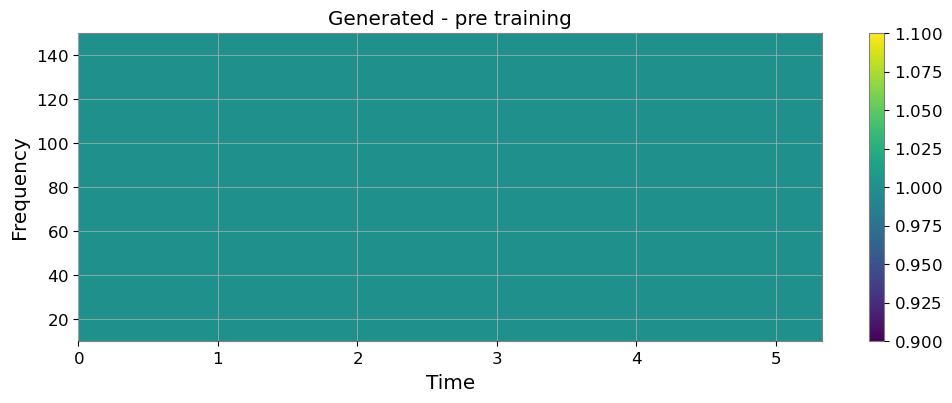

In [68]:
plt.figure(figsize=(12, 4))
plt.imshow(qplt_g, aspect='auto', extent=[0, 16/3, 10, 150])
plt.title('Generated - pre training')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()


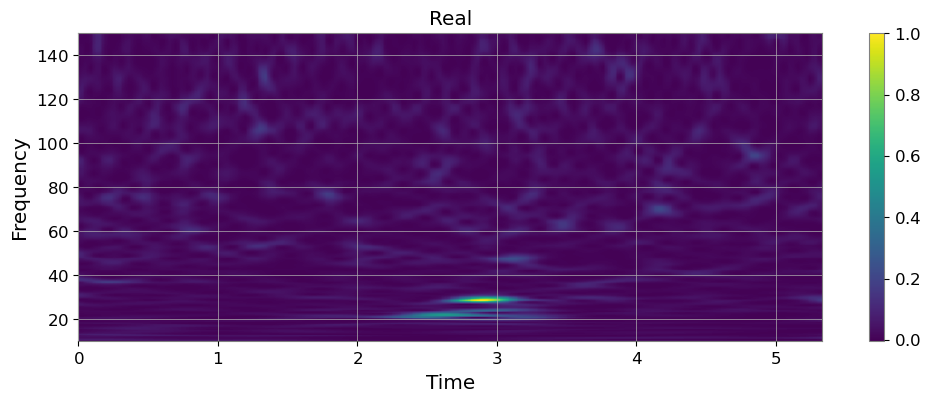

In [51]:
plt.figure(figsize=(12, 4))
plt.imshow(qplt_r, aspect='auto', extent=[0, 16/3, 10, 150])
plt.title('Real')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()